In [202]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Elecciones

In [130]:
# connect to data
import requests
import pandas as pd
election_url = "https://static01.nyt.com/elections-assets/2020/data/api/2020-11-03/national-map-page/national/president.json"

# make an http request for the page
election_request = requests.request(
    method='GET', 
    url=election_url,
    headers={ "Accept": "application/json" }
)

election_response = election_request.json()

election_data = election_response['data']['races']

## parse response into dataframe, and select and rename final columns
election_data_df = pd.DataFrame(election_data)[['state_name', 'counties']].rename(columns={"state_name": "t_state_name"})

# after https://stackoverflow.com/a/49962887
# unnest 'counties' column, turning object keys in dataframe columns and object values into rows, select certain keys from each array, and rename those keys (columns)
election_data_df = pd.DataFrame(
    [
        dict(y, t_state_name=i) for i, x in zip(
            election_data_df['t_state_name'],
            election_data_df['counties']
        ) for y in x
    ]
)[['fips', 'name', 'votes', 't_state_name', 'results']].rename(columns={"fips": "geoid", "votes": "total_votes", "name": "t_county_name"})

# after https://stackoverflow.com/a/38231651
## unravel dictionary (JSON object) into other columns, choose final columns, rename them, and cast their data types
election_data_df = pd.concat(
    [
        election_data_df.drop(['results'], axis=1), 
        election_data_df['results'].apply(pd.Series)
    ], 
    axis=1
)[['geoid', 't_county_name', 'total_votes', 't_state_name', 'trumpd', 'bidenj']].rename(columns={"trumpd": "votes_gop", "bidenj": "votes_dem"}).astype({'votes_gop': 'int64', 'votes_dem': 'int64'})

# create state FIPS codes from the 5-digit 'geoid'
election_data_df['fips'] = election_data_df['geoid']

election_data_df['dem_won'] = (election_data_df['votes_dem'] > election_data_df['votes_gop']).astype(int)
election_data_df['margin_votes'] = (election_data_df['votes_dem'] - election_data_df['votes_gop'])*100
election_data_df['margin_pct'] = (election_data_df['votes_dem'] - election_data_df['votes_gop'])*100 / (election_data_df['total_votes'])


elecciones de 2016 para robustez

In [186]:
election_data_df2016 = pd.read_csv("results2016.csv")
election_data_df2016['dem_won2016'] = (election_data_df['votes_dem'] > election_data_df['votes_gop']).astype(int)
election_data_df2016['margin_votes'] =( election_data_df2016['votes_dem'] - election_data_df2016['votes_gop'])*100
election_data_df2016['margin_pct'] = (election_data_df2016['votes_dem'] - election_data_df2016['votes_gop']) *100 / (election_data_df2016['total_votes'])
election_data_df2016

Unnamed: 0  votes_dem  votes_gop  total_votes   per_dem   per_gop  \
0              0    93003.0   130413.0     246588.0  0.377159  0.528870   
1              1    93003.0   130413.0     246588.0  0.377159  0.528870   
2              2    93003.0   130413.0     246588.0  0.377159  0.528870   
3              3    93003.0   130413.0     246588.0  0.377159  0.528870   
4              4    93003.0   130413.0     246588.0  0.377159  0.528870   
...          ...        ...        ...          ...       ...       ...   
3136        3136     3233.0    12153.0      16661.0  0.194046  0.729428   
3137        3137     7313.0     3920.0      12176.0  0.600608  0.321945   
3138        3138     1202.0     6154.0       8053.0  0.149261  0.764187   
3139        3139      532.0     2911.0       3715.0  0.143203  0.783580   
3140        3140      294.0     2898.0       3334.0  0.088182  0.869226   

        diff per_point_diff state_abbr        county_name  combined_fips  \
0     37,410         15.17%         AK             Alaska           2013   
1     37,410         15.17%         AK             Alaska           2016   
2     37,410         15.17%         AK             Alaska           2020   
3     37,410         15.17%         AK             Alaska           2050   
4     37,410         15.17%         AK             Alaska           2060   
...      ...            ...        ...                ...            ...   
3136   8,920         53.54%         WY  Sweetwater County          56037   
3137   3,393         27.87%         WY       Teton County          56039   
3138   4,952         61.49%         WY       Uinta County          56041   
3139   2,379         64.04%         WY    Washakie County          56043   
3140   2,604         78.10%         WY      Weston County          56045   

      dem_won2016  margin_votes  margin_pct  
0               0    -3741000.0  -15.171055  
1               0    -3741000.0  -15.171055  
2               0    -3741000.0  -15.171055  
3               0    -3741000.0  -15.171055  
4               0    -3741000.0  -15.171055  
...           ...           ...         ...  
3136            1     -892000.0  -53.538203  
3137            0      339300.0   27.866294  
3138            0     -495200.0  -61.492611  
3139            0     -237900.0  -64.037685  
3140            0     -260400.0  -78.104379  

[3141 rows x 14 columns]

In [187]:
election_data_df2016.rename(columns={"combined_fips": "fips","margin_pct": "margin_pct2016" }, inplace=True)
election_data_df2016['fips'] = election_data_df2016['fips'].astype(str)
df_stata2021 = pd.merge(df_stata2021,election_data_df2016[['dem_won2016', 'fips', 'margin_pct2016' ]], on='fips', how='left')
df_stata2021.to_stata('censo_margin_vacunasv2.dta', write_index=False)

In [132]:
election_data_df2016.rename(columns={"combined_fips": "fips","margin_pct": "margin_pct2016" }, inplace=True)
election_data_df2016['fips'] = election_data_df2016['fips'].astype(str)
df_merged = pd.merge(election_data_df2016[['dem_won2016', 'fips', 'margin_pct2016' ]], election_data_df, on='fips', how='inner')
df_filtrado = df_merged[ df_merged["dem_won"] == df_merged["dem_won2016"]]
 

# Censo

In [133]:
import requests
import pandas as pd

# Tu API key
API_KEY = '29caaead12373544ff9fb7db17cb01532b2e2468'


# Año y dataset: American Community Survey 5-year estimates
year = '2021'
dataset = 'acs/acs5'

variables = {
    'B01003_001E': 'total_population',
    'B19013_001E': 'median_income',
    'B17001_002E': 'population_below_poverty',
    'B01001_020E': 'males_65_66',    
    'B01001_021E': 'males_67_69',
    'B01001_044E': 'females_65_66',
    'B01001_045E': 'females_67_69',
    'B15003_022E': 'bachelor_degree',
    'B27010_017E': 'uninsured_total', 
    'C24050_002E': 'healthcare_employed',
    'B02001_002E': 'white',
    'B02001_003E': 'black',
    'B02001_005E': 'asian',
    'B03003_003E': 'hispanic'
}

var_string = ",".join(variables.keys())

 
url = f"https://api.census.gov/data/{year}/{dataset}?get=NAME,{var_string}&for=county:*&in=state:*&key={API_KEY}"

 
response = requests.get(url)

 
data = response.json()
columns = data[0]
rows = data[1:]
df_census = pd.DataFrame(rows, columns=columns)

 
print(df_census.head())


                      NAME B01003_001E B19013_001E B17001_002E B01001_020E  \
0  Autauga County, Alabama       58239       62660        7847         539   
1  Baldwin County, Alabama      227131       64346       20598        3257   
2  Barbour County, Alabama       25259       36422        5890         297   
3     Bibb County, Alabama       22412       54277        3558         265   
4   Blount County, Alabama       58884       52830        7720         589   

  B01001_021E B01001_044E B01001_045E B15003_022E B27010_017E C24050_002E  \
0         697         444         947        6507         300         200   
1        3777        3082        4624       33379        2984        1827   
2         423         199         612        1212         154         469   
3         363         173         457        1276          94         299   
4        1100         600        1091        3783         484         443   

  B02001_002E B02001_003E B02001_005E B03003_003E state county  
0  

In [134]:
# Renombrar columnas
df_census = df_census.rename(columns=variables)
# Convertir columnas numéricas
for col in variables.values():
    df_census[col] = pd.to_numeric(df_census[col], errors='coerce')



In [135]:
df_census['white_pct'] = pd.to_numeric(df_census['white'], errors='coerce')*100 / pd.to_numeric(df_census['total_population'], errors='coerce')
df_census['black_pct'] = pd.to_numeric(df_census['black'], errors='coerce')*100/ pd.to_numeric(df_census['total_population'], errors='coerce')
df_census['asian_pct'] = pd.to_numeric(df_census['asian'], errors='coerce')*100 / pd.to_numeric(df_census['total_population'], errors='coerce')
df_census['hispanic_pct'] = pd.to_numeric(df_census['hispanic'], errors='coerce')*100 / pd.to_numeric(df_census['total_population'], errors='coerce')
# Crear columna fips (2 dígitos state + 3 dígitos county)
df_census['fips'] = df_census['state'].str.zfill(2) + df_census['county'].str.zfill(3)

# Calcular adultos mayores 65+
df_census['adults_65plus'] = df_census['males_65_66'] + df_census['males_67_69'] + df_census['females_65_66'] + df_census['females_67_69']
df_census['pct_adults_65plus'] = df_census['adults_65plus']* 100 / df_census['total_population']

# Porcentaje con educación universitaria
df_census['pct_bachelor_degree'] = df_census['bachelor_degree']*100 / df_census['total_population']

# Porcentaje sin seguro médico
df_census['pct_uninsured'] = df_census['uninsured_total']*100/ df_census['total_population']

df_census['pct_healthcare_employed'] = df_census['healthcare_employed']*100 / df_census['total_population']

In [136]:
df_census['fips'] = df_census['state'].astype(str).str.zfill(2) + df_census['county'].astype(str).str.zfill(3)
df_census=df_census[['fips', 'pct_adults_65plus', 'pct_bachelor_degree', 'pct_uninsured', 'pct_healthcare_employed', 'white_pct', 'black_pct', 'asian_pct', 'hispanic_pct']]

In [137]:
df_filtrado=election_data_df

In [138]:
df_merged = pd.merge(df_filtrado, df_census, on='fips', how='inner')
df_merged

geoid t_county_name  total_votes t_state_name  votes_gop  votes_dem  \
0     01001       Autauga        27770      Alabama      19838       7503   
1     01003       Baldwin       109679      Alabama      83544      24578   
2     01005       Barbour        10518      Alabama       5622       4816   
3     01007          Bibb         9595      Alabama       7525       1986   
4     01009        Blount        27588      Alabama      24711       2640   
...     ...           ...          ...          ...        ...        ...   
3107  56037    Sweetwater        16603      Wyoming      12229       3823   
3108  56039         Teton        14677      Wyoming       4341       9848   
3109  56041         Uinta         9402      Wyoming       7496       1591   
3110  56043      Washakie         4012      Wyoming       3245        651   
3111  56045        Weston         3542      Wyoming       3107        360   

       fips  dem_won  margin_votes  margin_pct  pct_adults_65plus  \
0     01001        0      -1233500  -44.418437           4.510723   
1     01003        0      -5896600  -53.762343           6.489647   
2     01005        0        -80600   -7.663054           6.061206   
3     01007        0       -553900  -57.727983           5.613064   
4     01009        0      -2207100  -80.002175           5.740099   
...     ...      ...           ...         ...                ...   
3107  56037        0       -840600  -50.629404           5.270967   
3108  56039        1        550700   37.521292           5.887903   
3109  56041        0       -590500  -62.805786           5.605928   
3110  56043        0       -259400  -64.656032           7.839856   
3111  56045        0       -274700  -77.555054           6.573792   

      pct_bachelor_degree  pct_uninsured  pct_healthcare_employed  white_pct  \
0               11.172925       0.515119                 0.343412  75.130067   
1               14.695924       1.313779                 0.804382  84.547684   
2                4.798290       0.609684                 1.856764  45.508532   
3                5.693379       0.419418                 1.334107  75.941460   
4                6.424496       0.821955                 0.752327  92.451260   
...                   ...            ...                      ...        ...   
3107             8.130196       2.666101                 7.609694  86.829647   
3108            28.980660       2.101291                 1.651014  85.222351   
3109             7.945793       1.969387                 4.309252  92.127328   
3110            12.036560       0.669413                 4.325438  85.671988   
3111             9.838920       3.381222                10.912785  89.304890   

      black_pct  asian_pct  hispanic_pct  
0     19.694706   1.110939      3.047786  
1      8.759262   0.957597      4.681880  
2     47.448434   0.419652      4.655766  
3     22.322863   0.205247      2.828842  
4      1.290673   0.366823      9.530603  
...         ...        ...           ...  
3107   1.236487   1.146989     16.093172  
3108   0.711866   1.582401     14.940606  
3109   0.253485   0.180365      9.656820  
3110   0.012873   0.399073     14.379506  
3111   0.362792   0.754607      1.857495  

[3112 rows x 18 columns]

In [139]:
df_merged

geoid t_county_name  total_votes t_state_name  votes_gop  votes_dem  \
0     01001       Autauga        27770      Alabama      19838       7503   
1     01003       Baldwin       109679      Alabama      83544      24578   
2     01005       Barbour        10518      Alabama       5622       4816   
3     01007          Bibb         9595      Alabama       7525       1986   
4     01009        Blount        27588      Alabama      24711       2640   
...     ...           ...          ...          ...        ...        ...   
3107  56037    Sweetwater        16603      Wyoming      12229       3823   
3108  56039         Teton        14677      Wyoming       4341       9848   
3109  56041         Uinta         9402      Wyoming       7496       1591   
3110  56043      Washakie         4012      Wyoming       3245        651   
3111  56045        Weston         3542      Wyoming       3107        360   

       fips  dem_won  margin_votes  margin_pct  pct_adults_65plus  \
0     01001        0      -1233500  -44.418437           4.510723   
1     01003        0      -5896600  -53.762343           6.489647   
2     01005        0        -80600   -7.663054           6.061206   
3     01007        0       -553900  -57.727983           5.613064   
4     01009        0      -2207100  -80.002175           5.740099   
...     ...      ...           ...         ...                ...   
3107  56037        0       -840600  -50.629404           5.270967   
3108  56039        1        550700   37.521292           5.887903   
3109  56041        0       -590500  -62.805786           5.605928   
3110  56043        0       -259400  -64.656032           7.839856   
3111  56045        0       -274700  -77.555054           6.573792   

      pct_bachelor_degree  pct_uninsured  pct_healthcare_employed  white_pct  \
0               11.172925       0.515119                 0.343412  75.130067   
1               14.695924       1.313779                 0.804382  84.547684   
2                4.798290       0.609684                 1.856764  45.508532   
3                5.693379       0.419418                 1.334107  75.941460   
4                6.424496       0.821955                 0.752327  92.451260   
...                   ...            ...                      ...        ...   
3107             8.130196       2.666101                 7.609694  86.829647   
3108            28.980660       2.101291                 1.651014  85.222351   
3109             7.945793       1.969387                 4.309252  92.127328   
3110            12.036560       0.669413                 4.325438  85.671988   
3111             9.838920       3.381222                10.912785  89.304890   

      black_pct  asian_pct  hispanic_pct  
0     19.694706   1.110939      3.047786  
1      8.759262   0.957597      4.681880  
2     47.448434   0.419652      4.655766  
3     22.322863   0.205247      2.828842  
4      1.290673   0.366823      9.530603  
...         ...        ...           ...  
3107   1.236487   1.146989     16.093172  
3108   0.711866   1.582401     14.940606  
3109   0.253485   0.180365      9.656820  
3110   0.012873   0.399073     14.379506  
3111   0.362792   0.754607      1.857495  

[3112 rows x 18 columns]

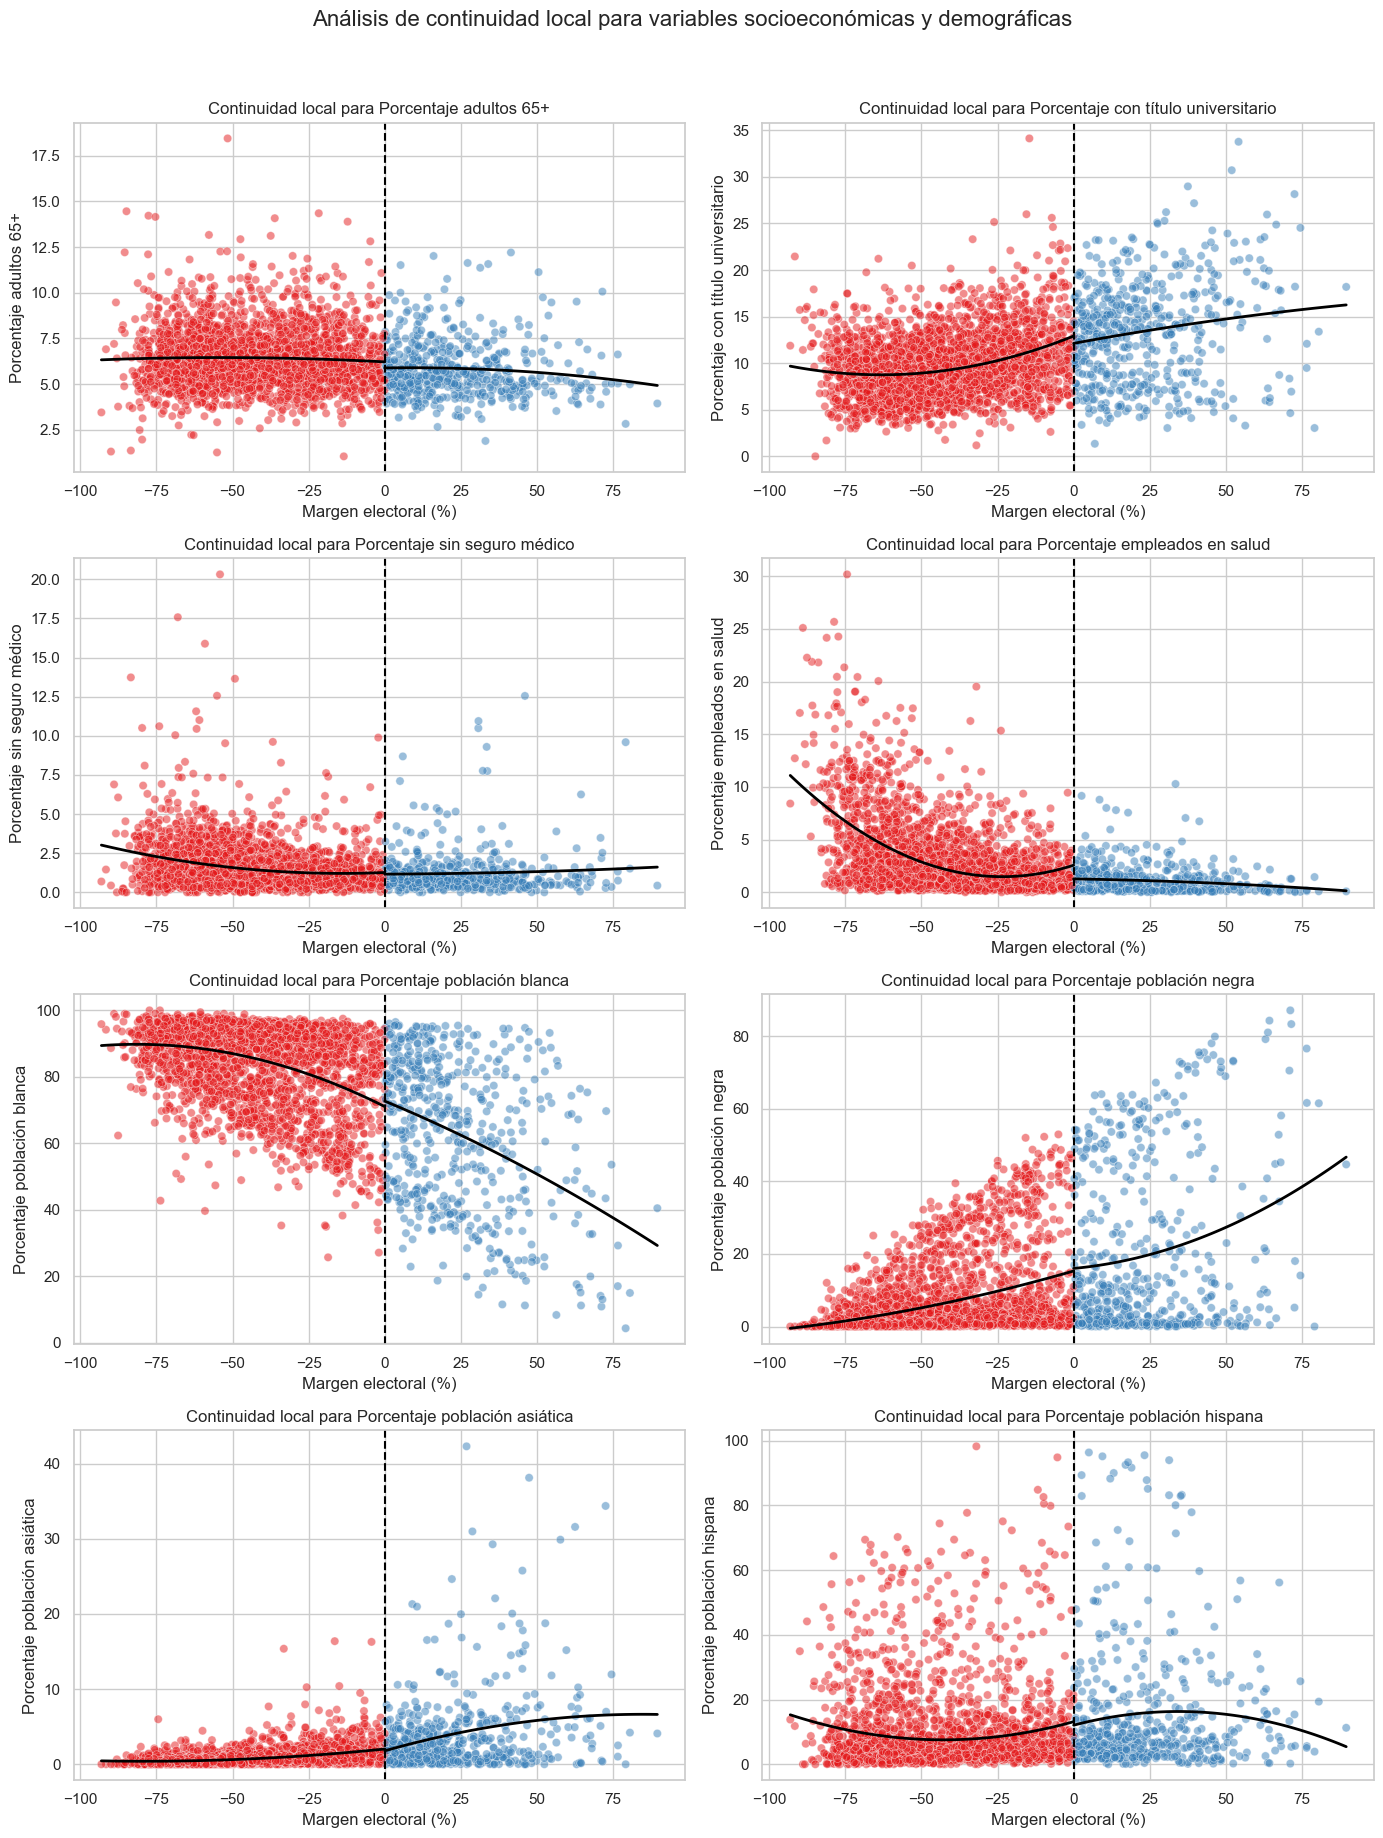

In [140]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns

variables = [
    'pct_adults_65plus', 'pct_bachelor_degree', 'pct_uninsured', 'pct_healthcare_employed',
    'white_pct', 'black_pct', 'asian_pct', 'hispanic_pct'
]

nombres_completos = {
    'pct_adults_65plus': 'Porcentaje adultos 65+',
    'pct_bachelor_degree': 'Porcentaje con título universitario',
    'pct_uninsured': 'Porcentaje sin seguro médico',
    'pct_healthcare_employed': 'Porcentaje empleados en salud',
    'white_pct': "Porcentaje población blanca",
    'black_pct': "Porcentaje población negra",
    'asian_pct': "Porcentaje población asiática",
    'hispanic_pct': "Porcentaje población hispana"
}

# Filtrar rango para evitar valores extremos en margin_pct
df_rango = df_merged[df_merged['margin_pct'].between(-500, 500)].copy()

fig, axes = plt.subplots(4, 2, figsize=(14, 18))  # 4 filas, 2 columnas
axes = axes.flatten()

for i, var in enumerate(variables):
    ax = axes[i]

    # Scatterplot con colores rojo y azul personalizados según 'dem_won'
    sns.scatterplot(
        x='margin_pct', y=var, hue='dem_won', data=df_rango,
        alpha=0.5, ax=ax, palette={0: '#E41A1C', 1: '#377EB8'}, legend=False
    )

    # Ajuste polinómico cuadrático a la izquierda (margin_pct < 0)
    df_left = df_rango[df_rango['margin_pct'] < 0]
    X_left = df_left['margin_pct']
    y_left = df_left[var]
    if len(X_left) > 2:
        X_poly_left = np.column_stack((X_left, X_left**2))
        X_poly_left = sm.add_constant(X_poly_left)
        model_left = sm.OLS(y_left, X_poly_left, missing='drop').fit()

        x_pred_left = np.linspace(X_left.min(), 0, 100)
        X_pred_poly_left = np.column_stack((x_pred_left, x_pred_left**2))
        X_pred_poly_left = sm.add_constant(X_pred_poly_left)
        y_pred_left = model_left.predict(X_pred_poly_left)
        ax.plot(x_pred_left, y_pred_left, color='black', lw=2, label='Polinomio izquierdo')

    # Ajuste polinómico cuadrático a la derecha (margin_pct >= 0)
    df_right = df_rango[df_rango['margin_pct'] >= 0]
    X_right = df_right['margin_pct']
    y_right = df_right[var]
    if len(X_right) > 2:
        X_poly_right = np.column_stack((X_right, X_right**2))
        X_poly_right = sm.add_constant(X_poly_right)
        model_right = sm.OLS(y_right, X_poly_right, missing='drop').fit()

        x_pred_right = np.linspace(0, X_right.max(), 100)
        X_pred_poly_right = np.column_stack((x_pred_right, x_pred_right**2))
        X_pred_poly_right = sm.add_constant(X_pred_poly_right)
        y_pred_right = model_right.predict(X_pred_poly_right)
        ax.plot(x_pred_right, y_pred_right, color='black', lw=2, label='Polinomio derecho')

    ax.axvline(0, color='black', linestyle='--')
    ax.set_xlabel('Margen electoral (%)')
    ax.set_ylabel(nombres_completos.get(var, var))
    ax.set_title(f'Continuidad local para {nombres_completos.get(var, var)}')
    ax.grid(True)
    

fig.suptitle('Análisis de continuidad local para variables socioeconómicas y demográficas', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [141]:
import numpy as np
import pandas as pd
from scipy import stats

windows = [5, 2.5, 1]

for w in windows:
    print(f"\n--- Test t para ventana ganar (+) o perder marginalmente (-) con ±{w} p.p ---")
    df_window = df_merged[df_merged['margin_pct'].between(-w, w)]
    
    count_0 = (df_window['dem_won'] == 0).sum()
    count_1 = (df_window['dem_won'] == 1).sum()
    total = len(df_window)
    print(f"Observaciones - dem_won=0: {count_0}, dem_won=1: {count_1}, total: {total}")
    
    for var in variables:
        group0 = df_window[df_window['dem_won'] == 0][var].dropna()
        group1 = df_window[df_window['dem_won'] == 1][var].dropna()
        
        t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False)
        
        print(f"{var}: t = {t_stat:.3f}, p = {p_val:.3f}")


--- Test t para ventana ganar (+) o perder marginalmente (-) con ±5 p.p ---
Observaciones - dem_won=0: 79, dem_won=1: 79, total: 158
pct_adults_65plus: t = 1.269, p = 0.206
pct_bachelor_degree: t = -0.536, p = 0.593
pct_uninsured: t = 0.816, p = 0.416
pct_healthcare_employed: t = 0.561, p = 0.576
white_pct: t = 0.402, p = 0.688
black_pct: t = -1.108, p = 0.270
asian_pct: t = -1.071, p = 0.286
hispanic_pct: t = -0.854, p = 0.395

--- Test t para ventana ganar (+) o perder marginalmente (-) con ±2.5 p.p ---
Observaciones - dem_won=0: 36, dem_won=1: 40, total: 76
pct_adults_65plus: t = -0.240, p = 0.811
pct_bachelor_degree: t = -1.683, p = 0.097
pct_uninsured: t = 1.209, p = 0.233
pct_healthcare_employed: t = 2.026, p = 0.048
white_pct: t = -0.220, p = 0.827
black_pct: t = -1.288, p = 0.202
asian_pct: t = -0.719, p = 0.474
hispanic_pct: t = -0.236, p = 0.814

--- Test t para ventana ganar (+) o perder marginalmente (-) con ±1 p.p ---
Observaciones - dem_won=0: 10, dem_won=1: 18, total: 2

In [75]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

windows = [5, 2.5, 1]

for w in windows:
    print(f"\n--- Test t para ventana ganar (+) o perder marginalmente (-) con ±{w} p.p ---")
    df_window = df_merged[df_merged['margin_pct'].between(-w, w)]
    
    count_0 = (df_window['dem_won'] == 0).sum()
    count_1 = (df_window['dem_won'] == 1).sum()
    total = len(df_window)
    print(f"Observaciones - dem_won=0: {count_0}, dem_won=1: {count_1}, total: {total}")
    
    for var in variables:
        group0 = df_window[df_window['dem_won'] == 0][var].dropna()
        group1 = df_window[df_window['dem_won'] == 1][var].dropna()
        
        t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False)
        
        # Cálculo del R²
        df_valid = df_window[['dem_won', var]].dropna()
        X = sm.add_constant(df_valid['dem_won'])
        y = df_valid[var]
        model = sm.OLS(y, X).fit()
        r2 = model.rsquared
        
        print(f"{var}: t = {t_stat:.3f}, p = {p_val:.3f}, R² = {r2:.3f}")



--- Test t para ventana ganar (+) o perder marginalmente (-) con ±5 p.p ---
Observaciones - dem_won=0: 79, dem_won=1: 79, total: 158
pct_adults_65plus: t = 1.269, p = 0.206, R² = 0.010
pct_bachelor_degree: t = -0.536, p = 0.593, R² = 0.002
pct_uninsured: t = 0.816, p = 0.416, R² = 0.004
pct_healthcare_employed: t = 0.561, p = 0.576, R² = 0.002
white_pct: t = 0.402, p = 0.688, R² = 0.001
black_pct: t = -1.108, p = 0.270, R² = 0.008
asian_pct: t = -1.071, p = 0.286, R² = 0.007
hispanic_pct: t = -0.854, p = 0.395, R² = 0.005

--- Test t para ventana ganar (+) o perder marginalmente (-) con ±2.5 p.p ---
Observaciones - dem_won=0: 36, dem_won=1: 40, total: 76
pct_adults_65plus: t = -0.240, p = 0.811, R² = 0.001
pct_bachelor_degree: t = -1.683, p = 0.097, R² = 0.037
pct_uninsured: t = 1.209, p = 0.233, R² = 0.021
pct_healthcare_employed: t = 2.026, p = 0.048, R² = 0.056
white_pct: t = -0.220, p = 0.827, R² = 0.001
black_pct: t = -1.288, p = 0.202, R² = 0.021
asian_pct: t = -0.719, p = 0.474

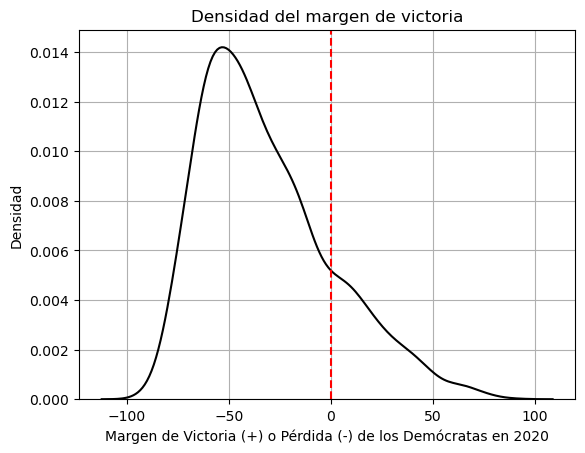

In [27]:


# Suponiendo que ya tienes un DataFrame llamado df con la variable margin_pct
sns.kdeplot(data=df_merged, x='margin_pct', color='black')

# Línea vertical en 0 (como `xline(0, lcol(red) lp("--"))` en Stata)
plt.axvline(x=0, color='red', linestyle='--')

# Opcional: etiquetas y estilo
plt.title('Densidad del margen de victoria')
plt.xlabel('Margen de Victoria (+) o Pérdida (-) de los Demócratas en 2020')
plt.ylabel('Densidad')
plt.grid(True)
plt.show()


In [185]:
df_stata2021.to_stata('censo_margin_vacunas.dta', write_index=False)

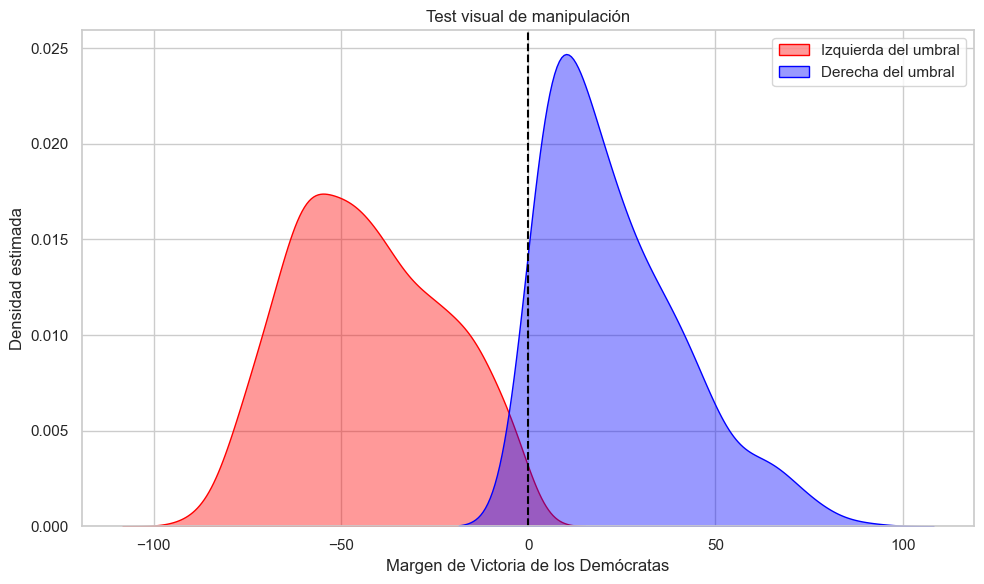

In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que no hay NaNs
df = df_merged.dropna(subset=['margin_pct'])

# Separar valores a la izquierda y derecha del umbral
left = df[df['margin_pct'] < 0]['margin_pct']
right = df[df['margin_pct'] >= 0]['margin_pct']

# Graficar estimación de densidad para ambos lados
plt.figure(figsize=(10, 6))
sns.kdeplot(left, label='Izquierda del umbral', color='red', fill=True, alpha=0.4, bw_adjust=1.2)
sns.kdeplot(right, label='Derecha del umbral', color='blue', fill=True, alpha=0.4, bw_adjust=1.2)

plt.axvline(0, color='black', linestyle='--')
plt.title('Test visual de manipulación')
plt.xlabel('Margen de Victoria de los Demócratas')
plt.ylabel('Densidad estimada')
plt.legend()
plt.tight_layout()
plt.show()


Call: rddensity

Sample Size:                                        3112
Cutoff:                                                0
Model:                                      unrestricted
Kernel:                                       triangular
VCE:                                           jackknife



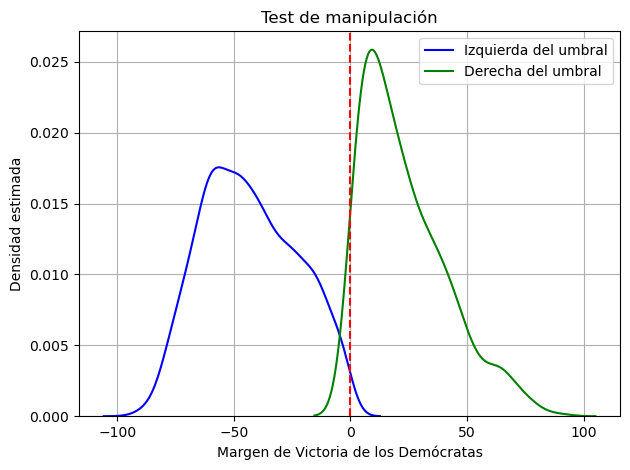

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rddensity import rddensity

# Supón que tu DataFrame se llama df y tiene la variable margin_pct
# df = pd.read_csv("tu_archivo.csv")  # si necesitas cargarlo

# 1. Test de manipulación
res = rddensity(df_merged['margin_pct'], c=0)
print(res)  # Esto imprime el resumen como en Stata

# 2. Gráfico KDE izquierda vs derecha
# Asumiendo que margin_pct está en un DataFrame llamado df
left = df_merged[df_merged['margin_pct'] < 0]['margin_pct']
right = df_merged[df_merged['margin_pct'] >= 0]['margin_pct']

sns.kdeplot(left, label='Izquierda del umbral', color='blue', bw_adjust=1)
sns.kdeplot(right, label='Derecha del umbral', color='green', bw_adjust=1)

plt.axvline(0, color='red', linestyle='--')

plt.title('Test de manipulación')
plt.xlabel('Margen de Victoria de los Demócratas')
plt.ylabel('Densidad estimada')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


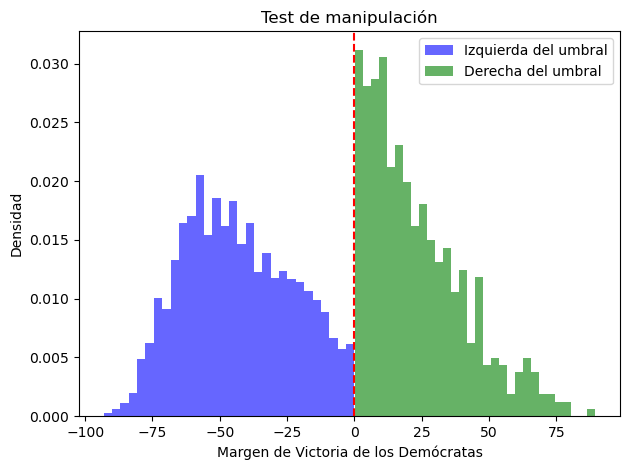

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Asumiendo que margin_pct está en un DataFrame llamado df
left = df_merged[df_merged['margin_pct'] < 0]['margin_pct']
right = df_merged[df_merged['margin_pct'] >= 0]['margin_pct']

# Crear gráfico KDE por lado

plt.hist(left, bins=30, density=True, alpha=0.6, color='blue', label='Izquierda del umbral')
plt.hist(right, bins=30, density=True, alpha=0.6, color='green', label='Derecha del umbral')
plt.axvline(0, color='red', linestyle='--')

plt.title('Test de manipulación')
plt.xlabel('Margen de Victoria de los Demócratas')
plt.ylabel('Densidad')
plt.legend()
plt.tight_layout()
plt.show()



# Vacunación

In [143]:
from sodapy import Socrata
import pandas as pd

# Conectar al portal de datos del CDC
client = Socrata("data.cdc.gov", None)

# Consultar solo los registros de diciembre de 2021
# Formato de fecha esperado: YYYY-MM-DDTHH:MM:SS (ISO8601)
results = client.get(
    "8xkx-amqh",
    where="date between '2021-05-01T00:00:00' and '2021-05-31T23:59:59'",
    limit=10000  # Puedes ajustar el límite según sea necesario
)

# Convertir a DataFrame
vacunas = pd.DataFrame.from_records(results)

# Mostrar los primeros registros
print(vacunas.head())

                      date   fips mmwr_week       recip_county recip_state  \
0  2021-05-01T00:00:00.000  37059        17       Davie County          NC   
1  2021-05-01T00:00:00.000  17189        17  Washington County          IL   
2  2021-05-01T00:00:00.000  06029        17        Kern County          CA   
3  2021-05-01T00:00:00.000  51580        17     Covington city          VA   
4  2021-05-01T00:00:00.000  36111        17      Ulster County          NY   

  completeness_pct administered_dose1_recip administered_dose1_pop_pct  \
0             96.4                    17006                       39.7   
1             97.6                     5728                       41.2   
2             96.9                   276004                       30.7   
3                0                        0                          0   
4             97.2                    89312                       50.3   

  administered_dose1_recip_12plus administered_dose1_recip_12pluspop_pct  ...  \
0    

In [192]:
df_stata2021

geoid t_county_name  total_votes t_state_name  votes_gop  votes_dem  \
0     01001       Autauga        27770      Alabama      19838       7503   
1     01003       Baldwin       109679      Alabama      83544      24578   
2     01005       Barbour        10518      Alabama       5622       4816   
3     01007          Bibb         9595      Alabama       7525       1986   
4     01009        Blount        27588      Alabama      24711       2640   
...     ...           ...          ...          ...        ...        ...   
3107  56037    Sweetwater        16603      Wyoming      12229       3823   
3108  56039         Teton        14677      Wyoming       4341       9848   
3109  56041         Uinta         9402      Wyoming       7496       1591   
3110  56043      Washakie         4012      Wyoming       3245        651   
3111  56045        Weston         3542      Wyoming       3107        360   

       fips  dem_won  margin_votes  margin_pct  ...  \
0     01001        0      -1233500  -44.418437  ...   
1     01003        0      -5896600  -53.762343  ...   
2     01005        0        -80600   -7.663054  ...   
3     01007        0       -553900  -57.727983  ...   
4     01009        0      -2207100  -80.002175  ...   
...     ...      ...           ...         ...  ...   
3107  56037        0       -840600  -50.629404  ...   
3108  56039        1        550700   37.521292  ...   
3109  56041        0       -590500  -62.805786  ...   
3110  56043        0       -259400  -64.656032  ...   
3111  56045        0       -274700  -77.555054  ...   

      series_complete_18pluspop_pct_svi  series_complete_65pluspop_pct_svi  \
0                                     5                                  6   
1                                     1                                  3   
2                                    13                                 14   
3                                     9                                 10   
4                                     5                                  6   
...                                 ...                                ...   
3107                                  6                                  7   
3108                                  4                                  4   
3109                                  6                                  7   
3110                                  6                                  7   
3111                                  5                                  7   

      metro_status  series_complete_pop_pct_ur_equity  \
0            Metro                                  1   
1            Metro                                  1   
2        Non-metro                                  5   
3            Metro                                  1   
4            Metro                                  1   
...            ...                                ...   
3107     Non-metro                                  5   
3108     Non-metro                                  8   
3109     Non-metro                                  5   
3110     Non-metro                                  5   
3111     Non-metro                                  5   

      series_complete_12pluspop_pct_ur_equity  \
0                                           1   
1                                           1   
2                                           5   
3                                           1   
4                                           1   
...                                       ...   
3107                                        5   
3108                                        8   
3109                                        5   
3110                                        6   
3111                                        5   

      series_complete_18pluspop_pct_ur_equity  \
0                                           1   
1                                           1   
2                                           5   
3            

In [144]:
df_unico_fips = vacunas.drop_duplicates(subset='fips', keep='first')

In [191]:
df_stata2021 = pd.merge(df_merged, df_unico_fips, on='fips', how='left')

In [146]:
df_stata =df_stata2021 

In [147]:
# Columnas que no queremos procesar
excluir = ['date', 'fips', 'mmwr_week', 'recip_county', 'recip_state', 'dem_won']

# Seleccionamos columnas que terminan en 'pct' y no están en la lista de exclusión
columnas_pct = [col for col in df_stata.columns if col.endswith('pct') and col not in excluir]

# Convertimos esas columnas a numéricas, forzando donde sea necesario
df_stata[columnas_pct] = df_stata[columnas_pct].apply(pd.to_numeric, errors='coerce')


# Calculamos los promedios por grupo
promedios = df_stata.groupby('dem_won')[columnas_pct].mean()

# Calculamos la diferencia: promedio(dem_won=1) - promedio(dem_won=0)
diferencia = promedios.loc[1] - promedios.loc[0]

# Mostramos resultados ordenados por magnitud de la diferencia
diferencia = diferencia.sort_values(ascending=False)

print(diferencia)

margin_pct                                66.344400
black_pct                                 13.766755
administered_dose1_recip_18pluspop_pct     9.906614
administered_dose1_recip_12pluspop_pct     9.489005
administered_dose1_pop_pct                 8.790227
administered_dose1_recip_65pluspop_pct     8.000221
hispanic_pct                               5.838509
series_complete_18pluspop_pct              4.810403
series_complete_65pluspop_pct              4.716257
series_complete_12pluspop_pct              4.588825
series_complete_pop_pct                    4.061096
asian_pct                                  3.012962
completeness_pct                           1.435155
white_pct                                -21.625917
dtype: float64


In [148]:
# Frecuencia y porcentaje de condados por dem_won
tab = df_merged['dem_won'].value_counts(dropna=False).sort_index()
tab_df = tab.reset_index()
tab_df.columns = ['dem_won', 'Frecuencia']
tab_df['Porcentaje'] = round(100 * tab_df['Frecuencia'] / tab_df['Frecuencia'].sum(), 2)

# Conteo de estados únicos por grupo (cuántos estados ganó cada partido)
unique_states = df_merged.groupby('dem_won')['t_state_name'].nunique().reset_index()
unique_states.columns = ['dem_won', 'Estados únicos']

# Calcular votos ganadores según el partido que ganó en cada condado
df_merged['votos_ganador'] = df_merged.apply(
    lambda row: row['votes_dem'] if row['dem_won'] == 1 else row['votes_gop'], axis=1
)

# Suma de votos por grupo
votos_total = df_merged.groupby('dem_won')['votos_ganador'].sum().reset_index()
votos_total.columns = ['dem_won', 'Votos ganadores']

# Unir todas las tablas
tab_df = tab_df.merge(unique_states, on='dem_won')
tab_df = tab_df.merge(votos_total, on='dem_won')

# Mostrar tabla final
print(tab_df.to_string(index=False))



 dem_won  Frecuencia  Porcentaje  Estados únicos  Votos ganadores
       0        2574       82.71              46         40531515
       1         538       17.29              48         58658437


In [149]:
df_unico_fips2=df_unico_fips[['fips','administered_dose1_pop_pct',
 'administered_dose1_recip_12pluspop_pct',
 'administered_dose1_recip_18pluspop_pct',
 'administered_dose1_recip_65pluspop_pct',
 'series_complete_pop_pct',
 'series_complete_12pluspop_pct',
 'series_complete_18pluspop_pct',
 'series_complete_65pluspop_pct']]
df_unico_fips2

fips administered_dose1_pop_pct administered_dose1_recip_12pluspop_pct  \
0     37059                       39.7                                   45.6   
1     17189                       41.2                                   47.6   
2     06029                       30.7                                   37.9   
3     51580                          0                                    0.0   
4     36111                       50.3                                   56.5   
...     ...                        ...                                    ...   
3277  28041                       24.8                                   28.2   
3278  55065                       44.4                                   52.5   
3279  38025                       17.4                                   21.1   
3280  05089                         25                                   28.4   
3281  17163                       43.8                                   51.8   

     administered_dose1_recip_18pluspop_pct  \
0                                      49.3   
1                                      51.7   
2                                      42.1   
3                                         0   
4                                      59.9   
...                                     ...   
3277                                   30.6   
3278                                   57.7   
3279                                   23.2   
3280                                   30.5   
3281                                   56.2   

     administered_dose1_recip_65pluspop_pct series_complete_pop_pct  \
0                                      75.3                    31.9   
1                                      80.6                    33.5   
2                                      72.5                    22.8   
3                                         0                       0   
4                                      76.7                    38.6   
...                                     ...                     ...   
3277                                   50.7                    13.8   
3278                                     88                    38.6   
3279                                   50.7                    13.6   
3280                                     49                    18.4   
3281                                   85.8                    32.9   

     series_complete_12pluspop_pct series_complete_18pluspop_pct  \
0                             36.7                          40.1   
1                             38.7                          42.3   
2                             28.2                          31.6   
3                              0.0                             0   
4                             43.4                          46.6   
...                            ...                           ...   
3277                          15.7                            17   
3278                          45.6                          50.4   
3279                          16.5                          18.1   
3280                          20.9                          22.5   
3281                          38.9                          42.3   

     series_complete_65pluspop_pct  
0                             68.1  
1                             69.6  
2                             60.4  
3                                0  
4                             67.7  
...                            ...  
3277                          42.3  
3278                          84.3  
3279                          42.9  
3280                          38.3  
3281                          66.7  

[3225 rows x 9 columns]

In [203]:
df_stata2021 = pd.merge(df_merged, df_unico_fips2, on='fips', how='left')

In [205]:
df_stata2021.columns.to_list()

['geoid',
 't_county_name',
 'total_votes',
 't_state_name',
 'votes_gop',
 'votes_dem',
 'fips',
 'dem_won',
 'margin_votes',
 'margin_pct',
 'pct_adults_65plus',
 'pct_bachelor_degree',
 'pct_uninsured',
 'pct_healthcare_employed',
 'white_pct',
 'black_pct',
 'asian_pct',
 'hispanic_pct',
 'votos_ganador',
 'administered_dose1_pop_pct',
 'administered_dose1_recip_12pluspop_pct',
 'administered_dose1_recip_18pluspop_pct',
 'administered_dose1_recip_65pluspop_pct',
 'series_complete_pop_pct',
 'series_complete_12pluspop_pct',
 'series_complete_18pluspop_pct',
 'series_complete_65pluspop_pct']

In [206]:
import pandas as pd


# Definir las columnas de vacunación
cols_vac = ['administered_dose1_pop_pct',
    'administered_dose1_recip_12pluspop_pct',
    'administered_dose1_recip_18pluspop_pct',
    'administered_dose1_recip_65pluspop_pct',
    'series_complete_pop_pct',
    'series_complete_12pluspop_pct',
    'series_complete_18pluspop_pct',
    'series_complete_65pluspop_pct']
for col in cols_vac:
    df_stata2021[col] = pd.to_numeric(df_stata2021[col], errors='coerce')

# Calcular los promedios por grupo dem_won
promedios = df_stata2021.groupby('dem_won')[cols_vac].mean().round(2)

# Mostrar tabla transpuesta (variables como filas)
tabla_resultado = promedios.transpose()
tabla_resultado.columns = ['Perdió Demócrata (0)', 'Ganó Demócrata (1)']

# Mostrar
print(tabla_resultado.to_string())


                                        Perdió Demócrata (0)  Ganó Demócrata (1)
administered_dose1_pop_pct                             26.28               35.07
administered_dose1_recip_12pluspop_pct                 29.35               38.84
administered_dose1_recip_18pluspop_pct                 32.05               41.96
administered_dose1_recip_65pluspop_pct                 52.78               60.78
series_complete_pop_pct                                22.33               26.39
series_complete_12pluspop_pct                          25.99               30.58
series_complete_18pluspop_pct                          28.48               33.29
series_complete_65pluspop_pct                          51.22               55.93


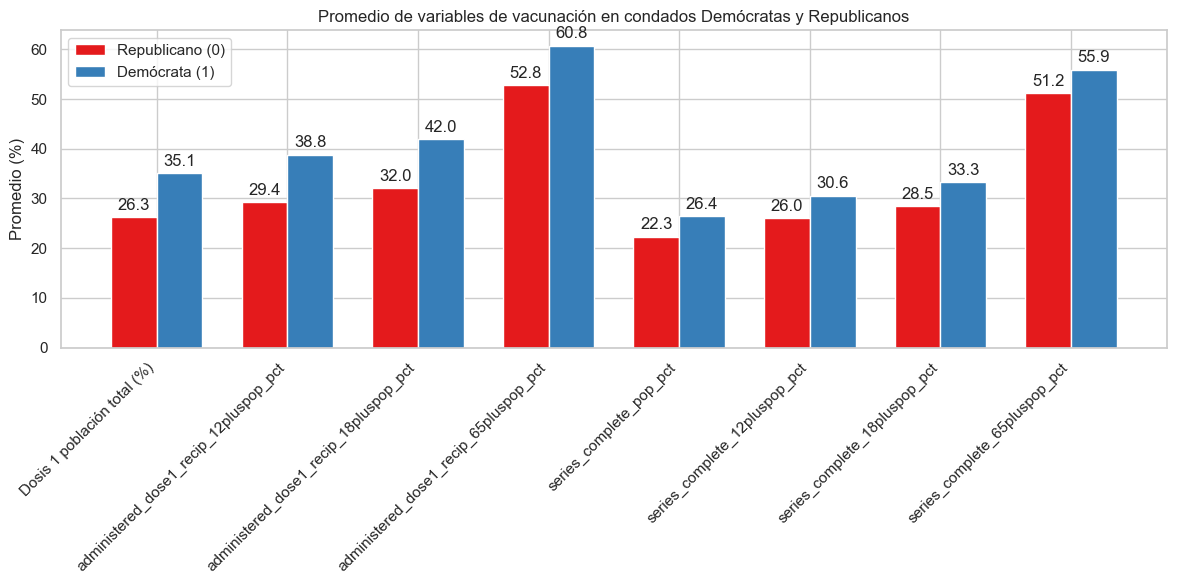

In [207]:
import matplotlib.pyplot as plt
import numpy as np

# Diccionario para renombrar las variables a etiquetas más legibles
rename_dict = {
    'administered_dose1_pop_pct': 'Dosis 1 población total (%)'
}

labels = tabla_resultado.index.tolist()
labels_renamed = [rename_dict.get(label, label) for label in labels]

valores_0 = tabla_resultado['Perdió Demócrata (0)'].values
valores_1 = tabla_resultado['Ganó Demócrata (1)'].values

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12,6))

# Cambié los colores aquí
bars0 = ax.bar(x - width/2, valores_0, width, label='Republicano (0)', color='#E41A1C')  # rojo
bars1 = ax.bar(x + width/2, valores_1, width, label='Demócrata (1)', color='#377EB8')   # azul

ax.set_ylabel('Promedio (%)')
ax.set_title('Promedio de variables de vacunación en condados Demócratas y Republicanos')
ax.set_xticks(x)
ax.set_xticklabels(labels_renamed, rotation=45, ha='right')

ax.legend()

def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars0)
autolabel(bars1)

plt.tight_layout()
plt.show()


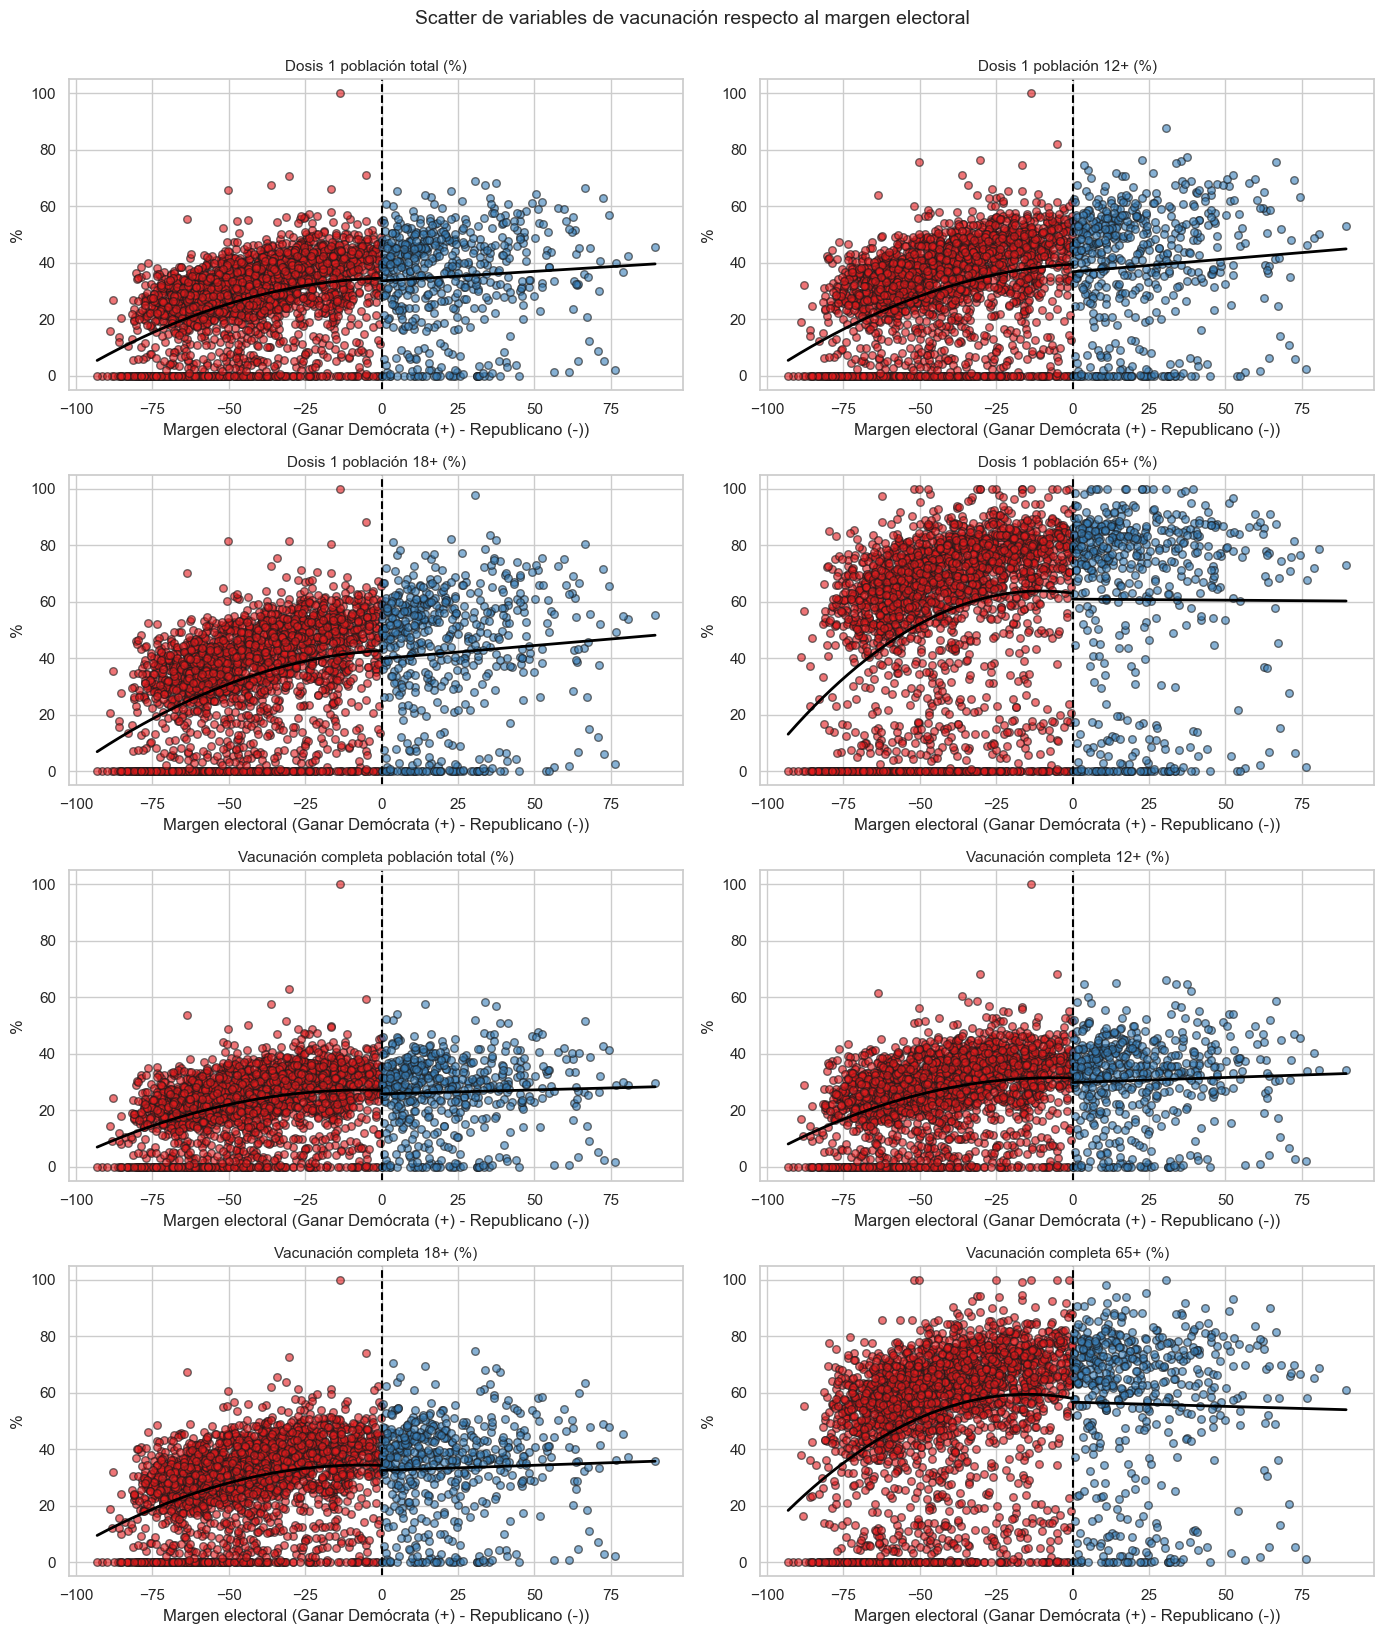

In [154]:
import matplotlib.pyplot as plt
import numpy as np

# Diccionario para renombrar las variables a etiquetas más legibles
rename_dict = {
    'administered_dose1_pop_pct': 'Dosis 1 población total (%)',
    'administered_dose1_recip_12pluspop_pct': 'Dosis 1 población 12+ (%)',
    'administered_dose1_recip_18pluspop_pct': 'Dosis 1 población 18+ (%)',
    'administered_dose1_recip_65pluspop_pct': 'Dosis 1 población 65+ (%)',
    'series_complete_pop_pct': 'Vacunación completa población total (%)',
    'series_complete_12pluspop_pct': 'Vacunación completa 12+ (%)',
    'series_complete_18pluspop_pct': 'Vacunación completa 18+ (%)',
    'series_complete_65pluspop_pct': 'Vacunación completa 65+ (%)'
}

variables = list(rename_dict.keys())
n_vars = len(variables)
n_cols = 2
n_rows = int(np.ceil(n_vars / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axs = axs.flatten()

for i, var in enumerate(variables):
    ax = axs[i]

    # Eliminar NaN antes de separar
    df_clean = df_stata2021[['margin_pct', var]].dropna()

    mask_left = df_clean['margin_pct'] < 0
    mask_right = df_clean['margin_pct'] >= 0

    x_left = df_clean.loc[mask_left, 'margin_pct']
    y_left = df_clean.loc[mask_left, var]

    x_right = df_clean.loc[mask_right, 'margin_pct']
    y_right = df_clean.loc[mask_right, var]

    # Scatter plot
    ax.scatter(x_left, y_left, color='#E41A1C', alpha=0.6, edgecolors='k', s=30, label='Izquierda del umbral')
    ax.scatter(x_right, y_right, color='#377EB8', alpha=0.6, edgecolors='k', s=30, label='Derecha del umbral')

    # Ajuste cuadrático a la izquierda
    if len(x_left) >= 3:
        coef_left = np.polyfit(x_left, y_left, 2)
        x_pred_left = np.linspace(x_left.min(), 0, 200)
        y_pred_left = np.polyval(coef_left, x_pred_left)
        ax.plot(x_pred_left, y_pred_left, color='black', lw=2, label='Polinomio izquierdo')

    # Ajuste lineal a la derecha
    if len(x_right) >= 2:
        coef_right = np.polyfit(x_right, y_right, 1)
        x_pred_right = np.linspace(0, x_right.max(), 200)
        y_pred_right = np.polyval(coef_right, x_pred_right)
        ax.plot(x_pred_right, y_pred_right, color='black', lw=2, label='Polinomio derecho')

    ax.axvline(x=0, color='black', linestyle='--')
    ax.set_title(rename_dict[var], fontsize=11)
    ax.set_xlabel('Margen electoral (Ganar Demócrata (+) - Republicano (-))')
    ax.set_ylabel('%')
    ax.grid(True)

   # ax.legend(fontsize=8)

# Elimina ejes vacíos si sobran
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.suptitle('Scatter de variables de vacunación respecto al margen electoral', fontsize=14, y=1.02)
plt.show()


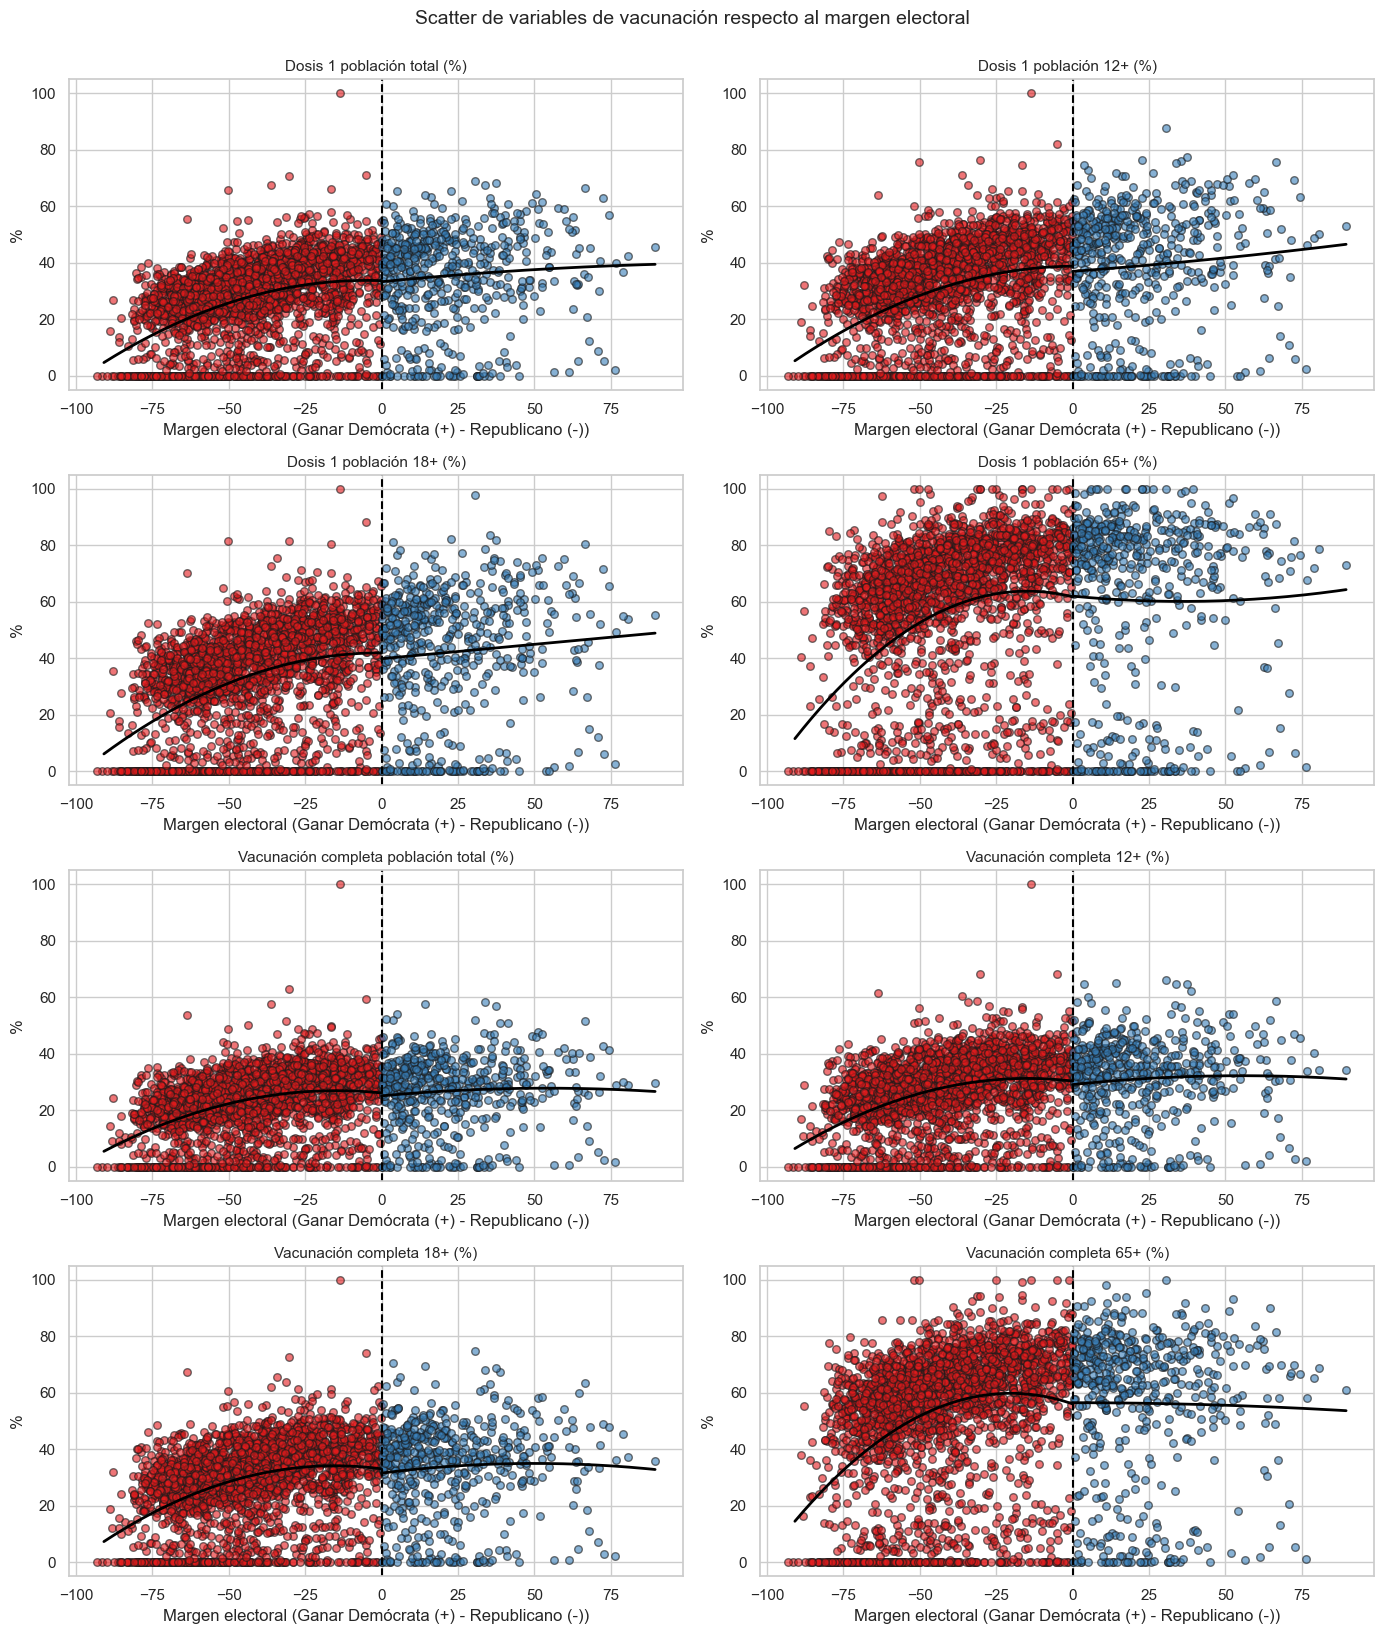

In [217]:
import matplotlib.pyplot as plt
import numpy as np

rename_dict = {
    'administered_dose1_pop_pct': 'Dosis 1 población total (%)',
    'administered_dose1_recip_12pluspop_pct': 'Dosis 1 población 12+ (%)',
    'administered_dose1_recip_18pluspop_pct': 'Dosis 1 población 18+ (%)',
    'administered_dose1_recip_65pluspop_pct': 'Dosis 1 población 65+ (%)',
    'series_complete_pop_pct': 'Vacunación completa población total (%)',
    'series_complete_12pluspop_pct': 'Vacunación completa 12+ (%)',
    'series_complete_18pluspop_pct': 'Vacunación completa 18+ (%)',
    'series_complete_65pluspop_pct': 'Vacunación completa 65+ (%)'
}

variables = list(rename_dict.keys())
n_vars = len(variables)
n_cols = 2
n_rows = int(np.ceil(n_vars / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axs = axs.flatten()

n_bins = 20  # ajusta el número de bins

for i, var in enumerate(variables):
    ax = axs[i]

    # Eliminar NaN antes de separar
    df_clean = df_stata2021[['margin_pct', var]].dropna()

    mask_left = df_clean['margin_pct'] < 0
    mask_right = df_clean['margin_pct'] >= 0

    x_left = df_clean.loc[mask_left, 'margin_pct']
    y_left = df_clean.loc[mask_left, var]

    x_right = df_clean.loc[mask_right, 'margin_pct']
    y_right = df_clean.loc[mask_right, var]

    # Scatter plot
    ax.scatter(x_left, y_left, color='#E41A1C', alpha=0.6, edgecolors='k', s=30, label='Izquierda del umbral')
    ax.scatter(x_right, y_right, color='#377EB8', alpha=0.6, edgecolors='k', s=30, label='Derecha del umbral')

    # Binning a la izquierda
    bins_left = np.linspace(x_left.min(), 0, n_bins+1)
    df_left = df_clean.loc[mask_left].copy()
    df_left['bin'] = pd.cut(df_left['margin_pct'], bins=bins_left, include_lowest=True)
    means_left = df_left.groupby('bin')[[var, 'margin_pct']].mean().dropna()

    if len(means_left) >= 3:
        try:
            coef_left = np.polyfit(means_left['margin_pct'], means_left[var], 2)
            x_pred_left = np.linspace(means_left['margin_pct'].min(), 0, 200)
            y_pred_left = np.polyval(coef_left, x_pred_left)
            ax.plot(x_pred_left, y_pred_left, color='black', lw=2, label='Polinomio izquierdo')
        except np.linalg.LinAlgError:
            print(f"No se pudo ajustar polinomio izquierdo para {var}")

    # Binning a la derecha
    bins_right = np.linspace(0, x_right.max(), n_bins+1)
    df_right = df_clean.loc[mask_right].copy()
    df_right['bin'] = pd.cut(df_right['margin_pct'], bins=bins_right, include_lowest=True)
    means_right = df_right.groupby('bin')[[var, 'margin_pct']].mean().dropna()

    if len(means_right) >= 2:
        try:
            coef_right = np.polyfit(means_right['margin_pct'], means_right[var], 2)
            x_pred_right = np.linspace(0, means_right['margin_pct'].max(), 200)
            y_pred_right = np.polyval(coef_right, x_pred_right)
            ax.plot(x_pred_right, y_pred_right, color='black', lw=2, label='Polinomio derecho')
        except np.linalg.LinAlgError:
            print(f"No se pudo ajustar polinomio derecho para {var}")

    ax.axvline(x=0, color='black', linestyle='--')
    ax.set_title(rename_dict[var], fontsize=11)
    ax.set_xlabel('Margen electoral (Ganar Demócrata (+) - Republicano (-))')
    ax.set_ylabel('%')
    ax.grid(True)

    #ax.legend(fontsize=8)

# Elimina ejes vacíos si sobran
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.suptitle('Scatter de variables de vacunación respecto al margen electoral', fontsize=14, y=1.02)
plt.show()


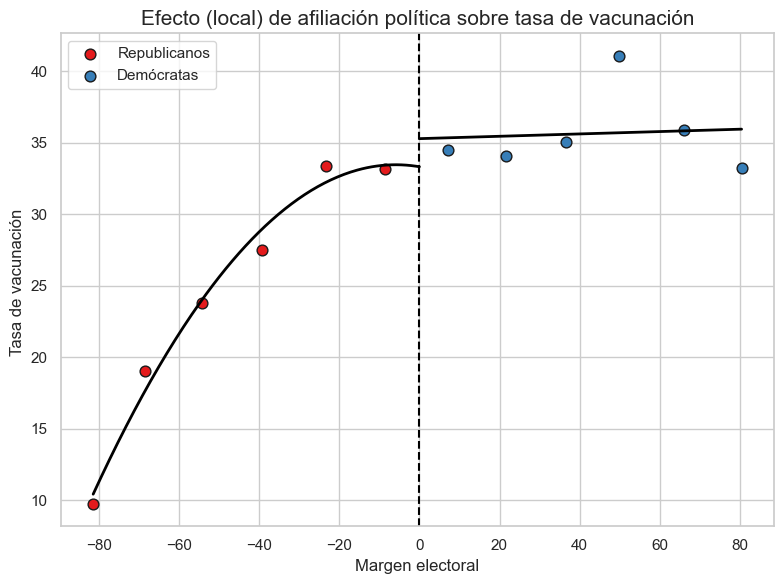

In [209]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Variable a graficar
var = 'administered_dose1_pop_pct'
df_clean = df_stata2021[['margin_pct', var]].dropna()

n_bins = 6  # Número de bins por lado

# Separar a izquierda y derecha
df_left = df_clean[df_clean['margin_pct'] < 0].copy()
df_right = df_clean[df_clean['margin_pct'] >= 0].copy()

# Crear bins para la izquierda (de min a 0)
bins_left = np.linspace(df_left['margin_pct'].min(), 0, n_bins + 1)
df_left['bin'] = pd.cut(df_left['margin_pct'], bins=bins_left, include_lowest=True)

# Crear bins para la derecha (de 0 a max)
bins_right = np.linspace(0, df_right['margin_pct'].max(), n_bins + 1)
df_right['bin'] = pd.cut(df_right['margin_pct'], bins=bins_right, include_lowest=True)

# Promedio por bin a la izquierda
means_left = df_left.groupby('bin').agg({
    'margin_pct': 'mean',
    var: 'mean'
}).dropna()

# Promedio por bin a la derecha
means_right = df_right.groupby('bin').agg({
    'margin_pct': 'mean',
    var: 'mean'
}).dropna()

# Graficar
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter puntos promedio (bins)
ax.scatter(means_left['margin_pct'], means_left[var], color='#E41A1C', s=60, edgecolors='k', label='Republicanos')
ax.scatter(means_right['margin_pct'], means_right[var], color='#377EB8', s=60, edgecolors='k', label='Demócratas')

# Ajuste polinomial izquierdo (cuadrático)
if len(means_left) >= 3:
    coef_left = np.polyfit(means_left['margin_pct'], means_left[var], 2)
    x_pred_left = np.linspace(means_left['margin_pct'].min(), 0, 200)
    y_pred_left = np.polyval(coef_left, x_pred_left)
    ax.plot(x_pred_left, y_pred_left, color='black', lw=2)

# Ajuste polinomial derecho (lineal)
if len(means_right) >= 2:
    coef_right = np.polyfit(means_right['margin_pct'], means_right[var], 1)
    x_pred_right = np.linspace(0, means_right['margin_pct'].max(), 200)
    y_pred_right = np.polyval(coef_right, x_pred_right)
    ax.plot(x_pred_right, y_pred_right, color='black', lw=2)

# Línea vertical umbral
ax.axvline(x=0, color='black', linestyle='--')

# Etiquetas y estilo
ax.set_title('Efecto (local) de afiliación política sobre tasa de vacunación', fontsize=15)
ax.set_xlabel('Margen electoral', fontsize=12)
ax.set_ylabel('Tasa de vacunación ', fontsize=12)
ax.grid(True)

# Mostrar leyenda con explicación de colores
ax.legend()

plt.tight_layout()
plt.show()




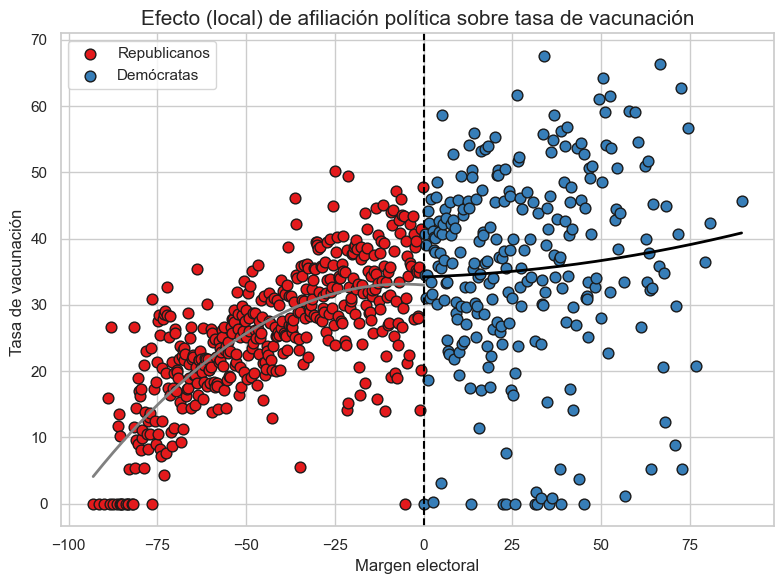

In [231]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Variable a graficar
var = 'administered_dose1_pop_pct'
df_clean = df_stata2021[['margin_pct', var]].dropna()

n_bins = 500  # Número de bins por lado

# Separar a izquierda y derecha
df_left = df_clean[df_clean['margin_pct'] < 0].copy()
df_right = df_clean[df_clean['margin_pct'] >= 0].copy()

# Crear bins para la izquierda (de min a 0)
bins_left = np.linspace(df_left['margin_pct'].min(), 0, n_bins + 1)
df_left['bin'] = pd.cut(df_left['margin_pct'], bins=bins_left, include_lowest=True)

# Crear bins para la derecha (de 0 a max)
bins_right = np.linspace(0, df_right['margin_pct'].max(), n_bins + 1)
df_right['bin'] = pd.cut(df_right['margin_pct'], bins=bins_right, include_lowest=True)

# Promedio por bin a la izquierda
means_left = df_left.groupby('bin').agg({
    'margin_pct': 'mean',
    var: 'mean'
}).dropna()

# Promedio por bin a la derecha
means_right = df_right.groupby('bin').agg({
    'margin_pct': 'mean',
    var: 'mean'
}).dropna()

# Graficar
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter puntos promedio (bins)
ax.scatter(means_left['margin_pct'], means_left[var], color='#E41A1C', s=60, edgecolors='k', label='Republicanos')
ax.scatter(means_right['margin_pct'], means_right[var], color='#377EB8', s=60, edgecolors='k', label='Demócratas')

# Ajuste polinomial izquierdo (cuadrático)
if len(means_left) >= 3:
    coef_left = np.polyfit(means_left['margin_pct'], means_left[var], 2)
    x_pred_left = np.linspace(means_left['margin_pct'].min(), 0, 200)
    y_pred_left = np.polyval(coef_left, x_pred_left)
    ax.plot(x_pred_left, y_pred_left, color='gray', lw=2)

# Ajuste polinomial derecho (lineal)
if len(means_right) >= 2:
    coef_right = np.polyfit(means_right['margin_pct'], means_right[var], 2)
    x_pred_right = np.linspace(0, means_right['margin_pct'].max(), 200)
    y_pred_right = np.polyval(coef_right, x_pred_right)
    ax.plot(x_pred_right, y_pred_right, color='black', lw=2)

# Línea vertical umbral
ax.axvline(x=0, color='black', linestyle='--')

# Etiquetas y estilo
ax.set_title('Efecto (local) de afiliación política sobre tasa de vacunación', fontsize=15)
ax.set_xlabel('Margen electoral', fontsize=12)
ax.set_ylabel('Tasa de vacunación ', fontsize=12)
ax.grid(True)

# Mostrar leyenda con explicación de colores
ax.legend()

plt.tight_layout()
plt.show()

In [194]:
df_stata2021 

geoid t_county_name  total_votes t_state_name  votes_gop  votes_dem  \
0     01001       Autauga        27770      Alabama      19838       7503   
1     01003       Baldwin       109679      Alabama      83544      24578   
2     01005       Barbour        10518      Alabama       5622       4816   
3     01007          Bibb         9595      Alabama       7525       1986   
4     01009        Blount        27588      Alabama      24711       2640   
...     ...           ...          ...          ...        ...        ...   
3107  56037    Sweetwater        16603      Wyoming      12229       3823   
3108  56039         Teton        14677      Wyoming       4341       9848   
3109  56041         Uinta         9402      Wyoming       7496       1591   
3110  56043      Washakie         4012      Wyoming       3245        651   
3111  56045        Weston         3542      Wyoming       3107        360   

       fips  dem_won  margin_votes  margin_pct  ...  \
0     01001        0      -1233500  -44.418437  ...   
1     01003        0      -5896600  -53.762343  ...   
2     01005        0        -80600   -7.663054  ...   
3     01007        0       -553900  -57.727983  ...   
4     01009        0      -2207100  -80.002175  ...   
...     ...      ...           ...         ...  ...   
3107  56037        0       -840600  -50.629404  ...   
3108  56039        1        550700   37.521292  ...   
3109  56041        0       -590500  -62.805786  ...   
3110  56043        0       -259400  -64.656032  ...   
3111  56045        0       -274700  -77.555054  ...   

      series_complete_18pluspop_pct_svi  series_complete_65pluspop_pct_svi  \
0                                     5                                  6   
1                                     1                                  3   
2                                    13                                 14   
3                                     9                                 10   
4                                     5                                  6   
...                                 ...                                ...   
3107                                  6                                  7   
3108                                  4                                  4   
3109                                  6                                  7   
3110                                  6                                  7   
3111                                  5                                  7   

      metro_status  series_complete_pop_pct_ur_equity  \
0            Metro                                  1   
1            Metro                                  1   
2        Non-metro                                  5   
3            Metro                                  1   
4            Metro                                  1   
...            ...                                ...   
3107     Non-metro                                  5   
3108     Non-metro                                  8   
3109     Non-metro                                  5   
3110     Non-metro                                  5   
3111     Non-metro                                  5   

      series_complete_12pluspop_pct_ur_equity  \
0                                           1   
1                                           1   
2                                           5   
3                                           1   
4                                           1   
...                                       ...   
3107                                        5   
3108                                        8   
3109                                        5   
3110                                        6   
3111                                        5   

      series_complete_18pluspop_pct_ur_equity  \
0                                           1   
1                                           1   
2                                           5   
3            

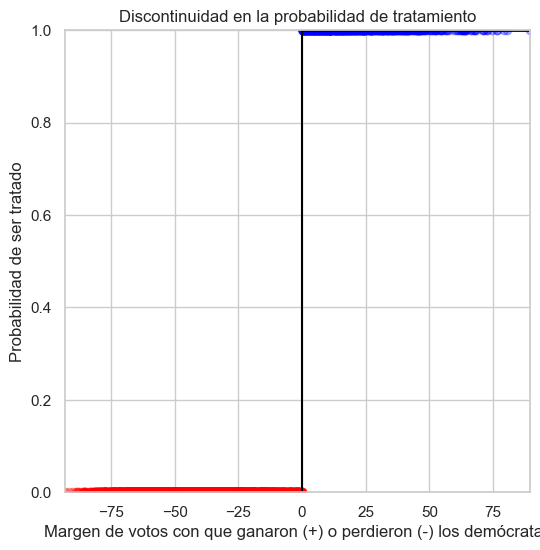

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

# Supongamos que tienes un DataFrame df con columnas 'margin_pct' y 'dem_won'

# Separar los datos izquierda y derecha
df_left = df_merged[ df_merged['margin_pct'] < 0]
df_right =  df_merged[ df_merged['margin_pct'] >= 0]

fig, ax = plt.subplots(figsize=(6, 6))

# Scatter izquierda rojo con transparencia
ax.scatter(df_left['margin_pct'], df_left['dem_won'], color='red', alpha=0.3, label='Margen < 0')

# Scatter derecha azul con transparencia
ax.scatter(df_right['margin_pct'], df_right['dem_won'], color='blue', alpha=0.3, label='Margen ≥ 0')

# Función para ajuste cuadrático (qfit)
def plot_qfit(x, y, ax):
    # Eliminar NaN
    x = x.dropna()
    y = y.loc[x.index].dropna()
    x = x.loc[y.index]

    X_poly = np.column_stack((x, x**2))
    X_poly = sm.add_constant(X_poly)
    model = sm.OLS(y, X_poly).fit()

    x_pred = np.linspace(x.min(), x.max(), 200)
    X_pred_poly = np.column_stack((x_pred, x_pred**2))
    X_pred_poly = sm.add_constant(X_pred_poly)
    y_pred = model.predict(X_pred_poly)

    ax.plot(x_pred, y_pred, color='black', lw=2)

# Ajuste izquierda
plot_qfit(df_left['margin_pct'], df_left['dem_won'], ax)

# Ajuste derecha
plot_qfit(df_right['margin_pct'], df_right['dem_won'], ax)

# Línea vertical en 0
ax.axvline(0, color='black')

# Límites y etiquetas
ax.set_ylim(0, 1)
ax.set_xlim( df_merged['margin_pct'].min(),  df_merged['margin_pct'].max())

ax.set_xlabel("Margen de votos con que ganaron (+) o perdieron (-) los demócratas")
ax.set_ylabel("Probabilidad de ser tratado")
ax.set_title("Discontinuidad en la probabilidad de tratamiento")

# Etiquetas en eje y desde 0 a 1 con paso 0.2
ax.set_yticks(np.arange(0, 1.1, 0.2))

# Leyenda (opcional, pero en el Stata estaba desactivada)
# ax.legend()

plt.show()


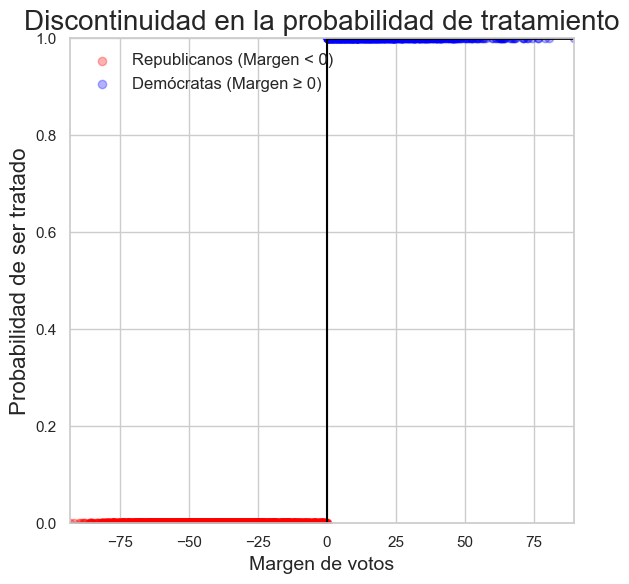

In [179]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

# Separar los datos izquierda y derecha
df_left = df_merged[df_merged['margin_pct'] < 0]
df_right = df_merged[df_merged['margin_pct'] >= 0]

fig, ax = plt.subplots(figsize=(6, 6))

# Scatter izquierda rojo con transparencia
ax.scatter(df_left['margin_pct'], df_left['dem_won'], color='red', alpha=0.3, label='Republicanos (Margen < 0)')

# Scatter derecha azul con transparencia
ax.scatter(df_right['margin_pct'], df_right['dem_won'], color='blue', alpha=0.3, label='Demócratas (Margen ≥ 0)')

# Función para ajuste cuadrático
def plot_qfit(x, y, ax):
    x = x.dropna()
    y = y.loc[x.index].dropna()
    x = x.loc[y.index]

    X_poly = np.column_stack((x, x**2))
    X_poly = sm.add_constant(X_poly)
    model = sm.OLS(y, X_poly).fit()

    x_pred = np.linspace(x.min(), x.max(), 200)
    X_pred_poly = np.column_stack((x_pred, x_pred**2))
    X_pred_poly = sm.add_constant(X_pred_poly)
    y_pred = model.predict(X_pred_poly)

    ax.plot(x_pred, y_pred, color='black', lw=2)

# Ajustes
plot_qfit(df_left['margin_pct'], df_left['dem_won'], ax)
plot_qfit(df_right['margin_pct'], df_right['dem_won'], ax)

# Línea de corte
ax.axvline(0, color='black')

# Límites y etiquetas
ax.set_ylim(0, 1)
ax.set_xlim(df_merged['margin_pct'].min(), df_merged['margin_pct'].max())

ax.set_xlabel("Margen de votos", fontsize=14)
ax.set_ylabel("Probabilidad de ser tratado", fontsize=16)
ax.set_title("Discontinuidad en la probabilidad de tratamiento", fontsize=20)

# Etiquetas eje y
ax.set_yticks(np.arange(0, 1.1, 0.2))

# Activar leyenda con fuente más grande
ax.legend(fontsize=12, loc='upper left', frameon=False)

plt.tight_layout()
plt.show()


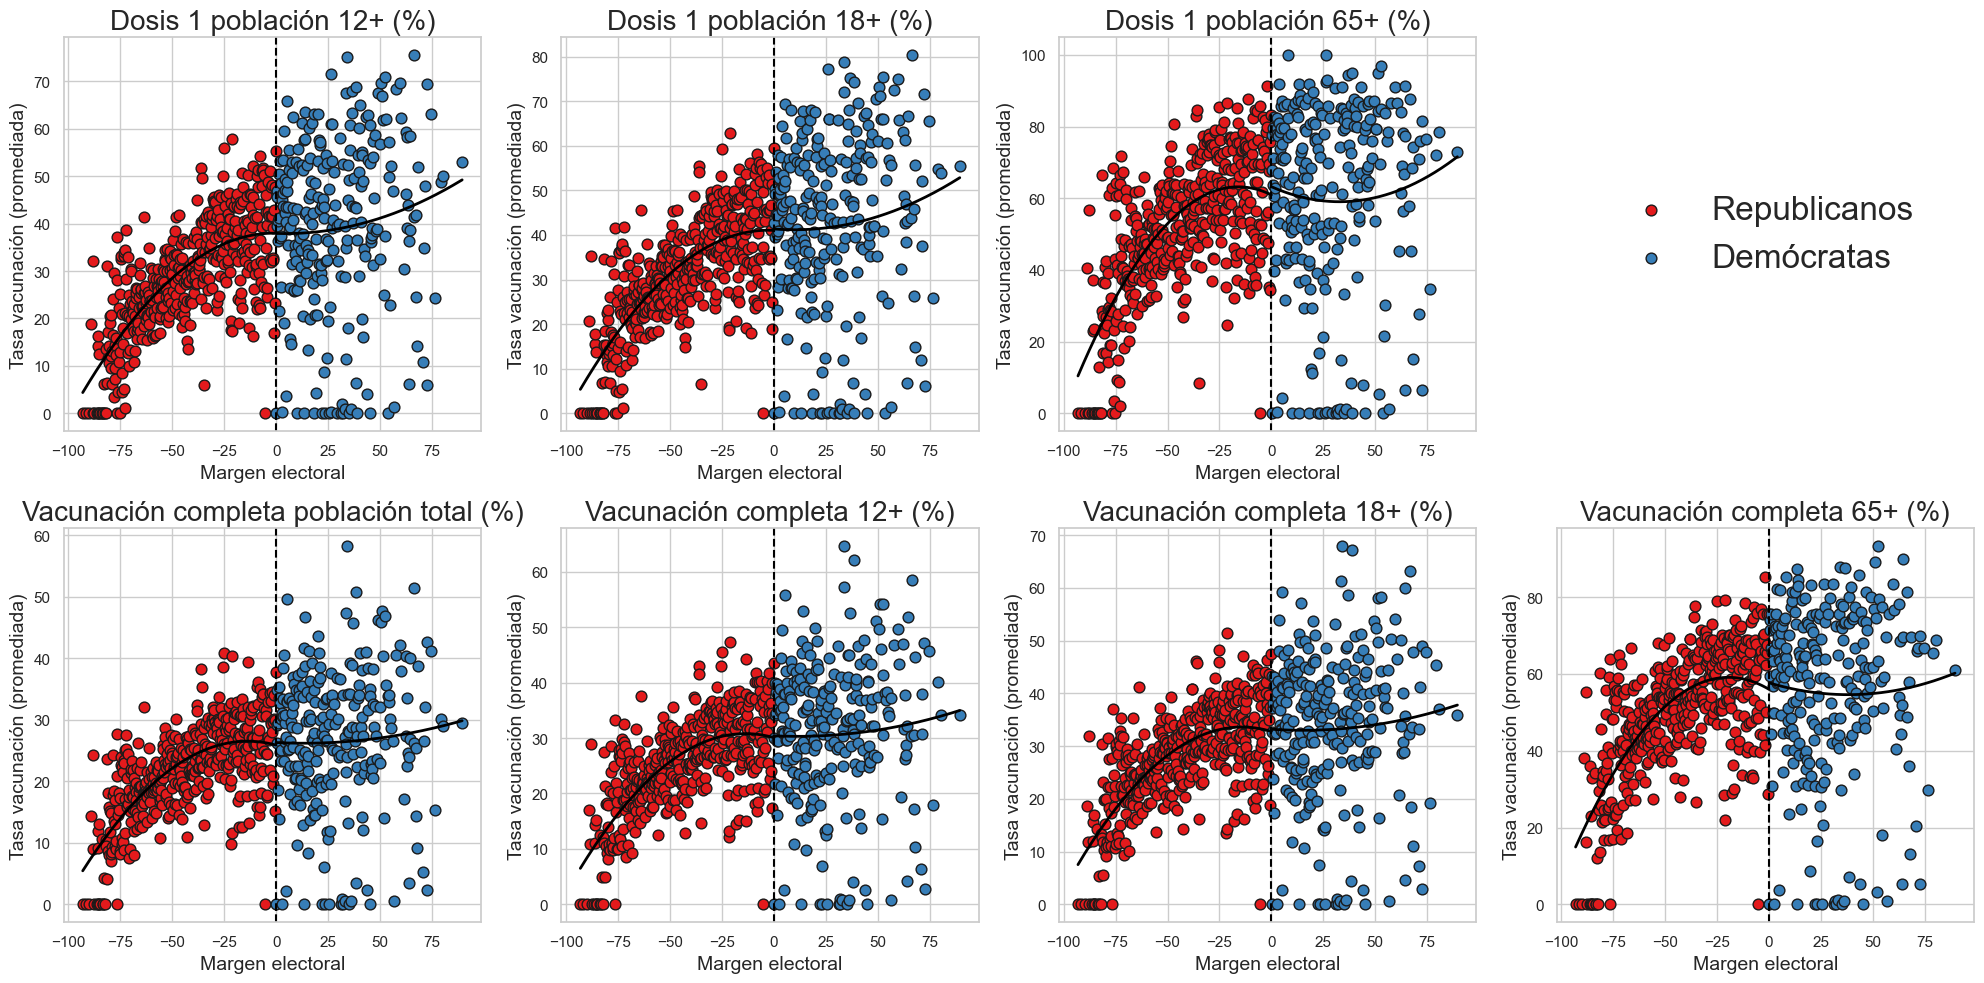

In [223]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec

rename_dict = {
    'administered_dose1_recip_12pluspop_pct': 'Dosis 1 población 12+ (%)',
    'administered_dose1_recip_18pluspop_pct': 'Dosis 1 población 18+ (%)',
    'administered_dose1_recip_65pluspop_pct': 'Dosis 1 población 65+ (%)',
    'series_complete_pop_pct': 'Vacunación completa población total (%)',
    'series_complete_12pluspop_pct': 'Vacunación completa 12+ (%)',
    'series_complete_18pluspop_pct': 'Vacunación completa 18+ (%)',
    'series_complete_65pluspop_pct': 'Vacunación completa 65+ (%)'
}

n_bins = 500
vars_list = list(rename_dict.items())

fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 4, figure=fig)

for i, (var, label) in enumerate(vars_list):
    if i < 3:
        ax = fig.add_subplot(gs[0, i])
    else:
        ax = fig.add_subplot(gs[1, i - 3])

    df_clean = df_stata2021[['margin_pct', var]].dropna()

    df_left = df_clean[df_clean['margin_pct'] < 0].copy()
    df_right = df_clean[df_clean['margin_pct'] >= 0].copy()

    bins_left = np.linspace(df_left['margin_pct'].min(), 0, n_bins + 1)
    df_left['bin'] = pd.cut(df_left['margin_pct'], bins=bins_left, include_lowest=True)

    bins_right = np.linspace(0, df_right['margin_pct'].max(), n_bins + 1)
    df_right['bin'] = pd.cut(df_right['margin_pct'], bins=bins_right, include_lowest=True)

    means_left = df_left.groupby('bin').agg({
        'margin_pct': 'mean',
        var: 'mean'
    }).dropna()

    means_right = df_right.groupby('bin').agg({
        'margin_pct': 'mean',
        var: 'mean'
    }).dropna()

    ax.scatter(means_left['margin_pct'], means_left[var], color='#E41A1C', s=60, edgecolors='k', label='Republicanos')
    ax.scatter(means_right['margin_pct'], means_right[var], color='#377EB8', s=60, edgecolors='k', label='Demócratas')

    if len(means_left) >= 3:
        coef_left = np.polyfit(means_left['margin_pct'], means_left[var], 2)
        x_pred_left = np.linspace(means_left['margin_pct'].min(), 0, 200)
        y_pred_left = np.polyval(coef_left, x_pred_left)
        ax.plot(x_pred_left, y_pred_left, color='black', lw=2)

    if len(means_right) >= 2:
        coef_right = np.polyfit(means_right['margin_pct'], means_right[var], 2)
        x_pred_right = np.linspace(0, means_right['margin_pct'].max(), 200)
        y_pred_right = np.polyval(coef_right, x_pred_right)
        ax.plot(x_pred_right, y_pred_right, color='black', lw=2)

    ax.axvline(x=0, color='black', linestyle='--')
    ax.set_title(label, fontsize=20)
    ax.set_xlabel('Margen electoral', fontsize=14)
    ax.set_ylabel('Tasa vacunación (promediada)', fontsize=14)
    ax.grid(True)

    y_min = min(means_left[var].min() if not means_left.empty else np.inf,
                means_right[var].min() if not means_right.empty else np.inf)
    y_max = max(means_left[var].max() if not means_left.empty else -np.inf,
                means_right[var].max() if not means_right.empty else -np.inf)
    if np.isfinite(y_min) and np.isfinite(y_max):
        margin = (y_max - y_min) * 0.05
        ax.set_ylim(y_min - margin, y_max + margin)

# Agregar leyenda en la celda vacía gs[0, 3]
ax_legend = fig.add_subplot(gs[0, 3])
ax_legend.axis('off')
ax_legend.scatter([], [], color='#E41A1C', edgecolors='k', s=60, label='Republicanos')
ax_legend.scatter([], [], color='#377EB8', edgecolors='k', s=60, label='Demócratas')
ax_legend.legend(loc='center', fontsize=24, frameon=False)

fig.tight_layout()
plt.show()




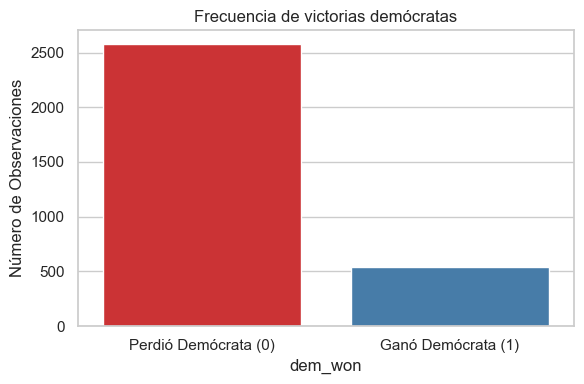

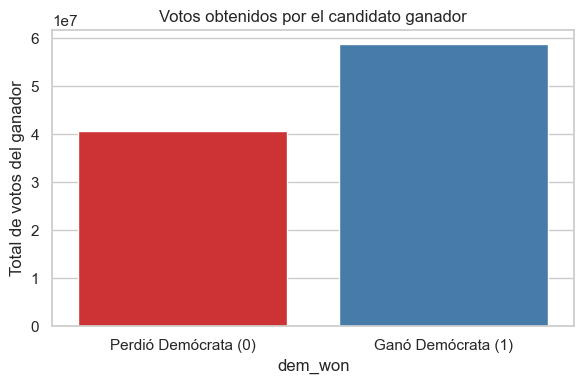

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo general
sns.set(style="whitegrid")
colors = ['#E41A1C', '#377EB8']  # Rojo demócrata, azul rival

# 1. Gráfico de Frecuencia
plt.figure(figsize=(6, 4))
sns.barplot(x='dem_won', y='Frecuencia', data=tab_df, palette=colors)
plt.xticks([0, 1], ['Perdió Demócrata (0)', 'Ganó Demócrata (1)'])
plt.ylabel('Número de Observaciones')
plt.title('Frecuencia de victorias demócratas')
plt.tight_layout()
plt.show()

# 2. Gráfico de Votos ganadores
plt.figure(figsize=(6, 4))
sns.barplot(x='dem_won', y='Votos ganadores', data=tab_df, palette=colors)
plt.xticks([0, 1], ['Perdió Demócrata (0)', 'Ganó Demócrata (1)'])
plt.ylabel('Total de votos del ganador')
plt.title('Votos obtenidos por el candidato ganador')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df_subset['total_votes'], bins=30, kde=True)
plt.title("Distribución de total_votes")
plt.xlabel("Total de votos")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

In [103]:
df_merged

geoid t_county_name  total_votes t_state_name  votes_gop  votes_dem  \
0     01001       Autauga        27770      Alabama      19838       7503   
1     01003       Baldwin       109679      Alabama      83544      24578   
2     01005       Barbour        10518      Alabama       5622       4816   
3     01007          Bibb         9595      Alabama       7525       1986   
4     01009        Blount        27588      Alabama      24711       2640   
...     ...           ...          ...          ...        ...        ...   
3107  56037    Sweetwater        16603      Wyoming      12229       3823   
3108  56039         Teton        14677      Wyoming       4341       9848   
3109  56041         Uinta         9402      Wyoming       7496       1591   
3110  56043      Washakie         4012      Wyoming       3245        651   
3111  56045        Weston         3542      Wyoming       3107        360   

       fips  dem_won  margin_votes  margin_pct  pct_adults_65plus  \
0     01001        0      -1233500  -44.418437           4.510723   
1     01003        0      -5896600  -53.762343           6.489647   
2     01005        0        -80600   -7.663054           6.061206   
3     01007        0       -553900  -57.727983           5.613064   
4     01009        0      -2207100  -80.002175           5.740099   
...     ...      ...           ...         ...                ...   
3107  56037        0       -840600  -50.629404           5.270967   
3108  56039        1        550700   37.521292           5.887903   
3109  56041        0       -590500  -62.805786           5.605928   
3110  56043        0       -259400  -64.656032           7.839856   
3111  56045        0       -274700  -77.555054           6.573792   

      pct_bachelor_degree  pct_uninsured  pct_healthcare_employed  white_pct  \
0               11.172925       0.515119                 0.343412  75.130067   
1               14.695924       1.313779                 0.804382  84.547684   
2                4.798290       0.609684                 1.856764  45.508532   
3                5.693379       0.419418                 1.334107  75.941460   
4                6.424496       0.821955                 0.752327  92.451260   
...                   ...            ...                      ...        ...   
3107             8.130196       2.666101                 7.609694  86.829647   
3108            28.980660       2.101291                 1.651014  85.222351   
3109             7.945793       1.969387                 4.309252  92.127328   
3110            12.036560       0.669413                 4.325438  85.671988   
3111             9.838920       3.381222                10.912785  89.304890   

      black_pct  asian_pct  hispanic_pct  votos_ganador  
0     19.694706   1.110939      3.047786          19838  
1      8.759262   0.957597      4.681880          83544  
2     47.448434   0.419652      4.655766           5622  
3     22.322863   0.205247      2.828842           7525  
4      1.290673   0.366823      9.530603          24711  
...         ...        ...           ...            ...  
3107   1.236487   1.146989     16.093172          12229  
3108   0.711866   1.582401     14.940606           9848  
3109   0.253485   0.180365      9.656820           7496  
3110   0.012873   0.399073     14.379506           3245  
3111   0.362792   0.754607      1.857495           3107  

[3112 rows x 19 columns]

In [109]:
df_stata

geoid t_county_name  total_votes t_state_name  votes_gop  votes_dem  \
0     01001       Autauga        27770      Alabama      19838       7503   
1     01003       Baldwin       109679      Alabama      83544      24578   
2     01005       Barbour        10518      Alabama       5622       4816   
3     01007          Bibb         9595      Alabama       7525       1986   
4     01009        Blount        27588      Alabama      24711       2640   
...     ...           ...          ...          ...        ...        ...   
3107  56037    Sweetwater        16603      Wyoming      12229       3823   
3108  56039         Teton        14677      Wyoming       4341       9848   
3109  56041         Uinta         9402      Wyoming       7496       1591   
3110  56043      Washakie         4012      Wyoming       3245        651   
3111  56045        Weston         3542      Wyoming       3107        360   

       fips  dem_won  margin_votes  margin_pct  ...  \
0     01001        0      -1233500  -44.418437  ...   
1     01003        0      -5896600  -53.762343  ...   
2     01005        0        -80600   -7.663054  ...   
3     01007        0       -553900  -57.727983  ...   
4     01009        0      -2207100  -80.002175  ...   
...     ...      ...           ...         ...  ...   
3107  56037        0       -840600  -50.629404  ...   
3108  56039        1        550700   37.521292  ...   
3109  56041        0       -590500  -62.805786  ...   
3110  56043        0       -259400  -64.656032  ...   
3111  56045        0       -274700  -77.555054  ...   

      series_complete_18pluspop_pct_svi  series_complete_65pluspop_pct_svi  \
0                                     5                                  6   
1                                     1                                  3   
2                                    13                                 14   
3                                     9                                 10   
4                                     5                                  6   
...                                 ...                                ...   
3107                                  6                                  7   
3108                                  4                                  4   
3109                                  6                                  7   
3110                                  6                                  7   
3111                                  5                                  7   

      metro_status  series_complete_pop_pct_ur_equity  \
0            Metro                                  1   
1            Metro                                  1   
2        Non-metro                                  5   
3            Metro                                  1   
4            Metro                                  1   
...            ...                                ...   
3107     Non-metro                                  5   
3108     Non-metro                                  8   
3109     Non-metro                                  5   
3110     Non-metro                                  5   
3111     Non-metro                                  5   

      series_complete_12pluspop_pct_ur_equity  \
0                                           1   
1                                           1   
2                                           5   
3                                           1   
4                                           1   
...                                       ...   
3107                                        5   
3108                                        8   
3109                                        5   
3110                                        6   
3111                                        5   

      series_complete_18pluspop_pct_ur_equity  \
0                                           1   
1                                           1   
2                                           5   
3            

In [ ]:
df_stata2021.to_stata('censo_margin_vacunas.dta', write_index=False)